In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=0,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.w2 = nn.Linear(self.attn_input, self.attn_output, )# bias=False)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'

schema_root = root+'schema2.txt'

relation_data = root+'skincare_mr.train'
dev_data = root+'skincare_mr.dev'
test_data = root+'skincare_mr.test'

# relation_data = root+'facial_r3_len60.train'
# dev_data = root+'facial_r3_len60.dev'
# test_data = root+'facial_r3_len60.test'

# relation_data = root+'facial_r3_len70.train'
# dev_data = root+'facial_r3_len70.dev'
# test_data = root+'facial_r3_len70.test'

# relation_data = root+'facial_r3_len80.train'
# dev_data = root+'facial_r3_len80.dev'
# test_data = root+'facial_r3_len80.test'



UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 100     # original 100
BATCH_SIZE = 32

EMBEDDING_DIM = 40   # original 40
HIDDEN_DIM1 = 20     # original 20
HIDDEN_DIM2 = 16     # original 16
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 10        # original 6       

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
# criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 400
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

loss = 0
start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))


  0%|          | 1/400 [00:10<1:07:12, 10.11s/it]

epoch: 1 | ent loss 0.7442 | rel loss 0.0305 | total loss 0.7747
         | val ent loss 0.5216 | val rel loss 0.0271


  0%|          | 2/400 [00:20<1:07:39, 10.20s/it]

epoch: 2 | ent loss 0.5577 | rel loss 0.0085 | total loss 0.5662
         | val ent loss 0.6932 | val rel loss 0.0098


  1%|          | 3/400 [00:30<1:07:17, 10.17s/it]

epoch: 3 | ent loss 0.5592 | rel loss 0.0092 | total loss 0.5684
         | val ent loss 0.9077 | val rel loss 0.0112


  1%|          | 4/400 [00:40<1:07:34, 10.24s/it]

epoch: 4 | ent loss 0.6070 | rel loss 0.0097 | total loss 0.6168
         | val ent loss 0.4353 | val rel loss 0.0095


  1%|▏         | 5/400 [00:51<1:07:52, 10.31s/it]

epoch: 5 | ent loss 0.5428 | rel loss 0.0094 | total loss 0.5522
         | val ent loss 0.4182 | val rel loss 0.0058


  2%|▏         | 6/400 [01:01<1:07:48, 10.33s/it]

epoch: 6 | ent loss 0.4218 | rel loss 0.0081 | total loss 0.4299
         | val ent loss 0.5015 | val rel loss 0.0051


  2%|▏         | 7/400 [01:12<1:08:15, 10.42s/it]

epoch: 7 | ent loss 0.4784 | rel loss 0.0074 | total loss 0.4858
         | val ent loss 0.3450 | val rel loss 0.0066


  2%|▏         | 8/400 [01:23<1:08:24, 10.47s/it]

epoch: 8 | ent loss 0.3194 | rel loss 0.0089 | total loss 0.3283
         | val ent loss 0.4387 | val rel loss 0.0142


  2%|▏         | 9/400 [01:34<1:08:28, 10.51s/it]

epoch: 9 | ent loss 0.2931 | rel loss 0.0059 | total loss 0.2990
         | val ent loss 0.4639 | val rel loss 0.0051


  2%|▎         | 10/400 [01:44<1:08:10, 10.49s/it]

epoch: 10 | ent loss 0.2737 | rel loss 0.0048 | total loss 0.2786
          | val ent loss 0.2204 | val rel loss 0.0118


  3%|▎         | 11/400 [01:55<1:08:05, 10.50s/it]

epoch: 11 | ent loss 0.2784 | rel loss 0.0038 | total loss 0.2822
          | val ent loss 0.3731 | val rel loss 0.0044


  3%|▎         | 12/400 [02:06<1:07:58, 10.51s/it]

epoch: 12 | ent loss 0.2205 | rel loss 0.0079 | total loss 0.2284
          | val ent loss 0.1399 | val rel loss 0.0048


  3%|▎         | 13/400 [02:16<1:07:54, 10.53s/it]

epoch: 13 | ent loss 0.1325 | rel loss 0.0065 | total loss 0.1390
          | val ent loss 0.2298 | val rel loss 0.0128


  4%|▎         | 14/400 [02:27<1:07:55, 10.56s/it]

epoch: 14 | ent loss 0.0914 | rel loss 0.0058 | total loss 0.0972
          | val ent loss 0.0624 | val rel loss 0.0065


  4%|▍         | 15/400 [02:38<1:07:47, 10.56s/it]

epoch: 15 | ent loss 0.0899 | rel loss 0.0079 | total loss 0.0978
          | val ent loss 0.1143 | val rel loss 0.0107


  4%|▍         | 16/400 [02:49<1:07:39, 10.57s/it]

epoch: 16 | ent loss 0.0700 | rel loss 0.0065 | total loss 0.0765
          | val ent loss 0.0287 | val rel loss 0.0055


  4%|▍         | 17/400 [02:59<1:07:28, 10.57s/it]

epoch: 17 | ent loss 0.0639 | rel loss 0.0084 | total loss 0.0723
          | val ent loss 0.0464 | val rel loss 0.0078


  4%|▍         | 18/400 [03:10<1:07:21, 10.58s/it]

epoch: 18 | ent loss 0.0840 | rel loss 0.0060 | total loss 0.0900
          | val ent loss 0.0671 | val rel loss 0.0061


  5%|▍         | 19/400 [03:20<1:07:07, 10.57s/it]

epoch: 19 | ent loss 0.0512 | rel loss 0.0037 | total loss 0.0549
          | val ent loss 0.1151 | val rel loss 0.0043


  5%|▌         | 20/400 [03:31<1:07:01, 10.58s/it]

epoch: 20 | ent loss 0.0351 | rel loss 0.0035 | total loss 0.0386
          | val ent loss 0.1335 | val rel loss 0.0024


  5%|▌         | 21/400 [03:42<1:06:59, 10.61s/it]

epoch: 21 | ent loss 0.0420 | rel loss 0.0042 | total loss 0.0462
          | val ent loss 0.0932 | val rel loss 0.0029


  6%|▌         | 22/400 [03:53<1:06:52, 10.62s/it]

epoch: 22 | ent loss 0.0743 | rel loss 0.0036 | total loss 0.0779
          | val ent loss 0.1744 | val rel loss 0.0036


  6%|▌         | 23/400 [04:04<1:06:51, 10.64s/it]

epoch: 23 | ent loss 0.0139 | rel loss 0.0030 | total loss 0.0169
          | val ent loss 0.1152 | val rel loss 0.0042


  6%|▌         | 24/400 [04:15<1:06:43, 10.65s/it]

epoch: 24 | ent loss 0.0647 | rel loss 0.0028 | total loss 0.0675
          | val ent loss 0.0109 | val rel loss 0.0047


  6%|▋         | 25/400 [04:26<1:06:39, 10.67s/it]

epoch: 25 | ent loss 0.0274 | rel loss 0.0034 | total loss 0.0307
          | val ent loss 0.1505 | val rel loss 0.0027


  6%|▋         | 26/400 [04:38<1:06:40, 10.70s/it]

epoch: 26 | ent loss 0.0384 | rel loss 0.0035 | total loss 0.0419
          | val ent loss 0.0778 | val rel loss 0.0031


  7%|▋         | 27/400 [04:49<1:06:45, 10.74s/it]

epoch: 27 | ent loss 0.0265 | rel loss 0.0031 | total loss 0.0296
          | val ent loss 0.0873 | val rel loss 0.0043


  7%|▋         | 28/400 [05:01<1:06:44, 10.76s/it]

epoch: 28 | ent loss 0.0457 | rel loss 0.0029 | total loss 0.0486
          | val ent loss 0.0745 | val rel loss 0.0014


  7%|▋         | 29/400 [05:12<1:06:43, 10.79s/it]

epoch: 29 | ent loss 0.0195 | rel loss 0.0024 | total loss 0.0219
          | val ent loss 0.0989 | val rel loss 0.0044


  8%|▊         | 30/400 [05:24<1:06:36, 10.80s/it]

epoch: 30 | ent loss 0.0222 | rel loss 0.0033 | total loss 0.0254
          | val ent loss 0.0762 | val rel loss 0.0018


  8%|▊         | 31/400 [05:35<1:06:32, 10.82s/it]

epoch: 31 | ent loss 0.0244 | rel loss 0.0023 | total loss 0.0267
          | val ent loss 0.0195 | val rel loss 0.0021


  8%|▊         | 32/400 [05:46<1:06:28, 10.84s/it]

epoch: 32 | ent loss 0.0177 | rel loss 0.0022 | total loss 0.0199
          | val ent loss 0.0966 | val rel loss 0.0029


  8%|▊         | 33/400 [05:58<1:06:23, 10.85s/it]

epoch: 33 | ent loss 0.0150 | rel loss 0.0030 | total loss 0.0180
          | val ent loss 0.0830 | val rel loss 0.0034


  8%|▊         | 34/400 [06:09<1:06:17, 10.87s/it]

epoch: 34 | ent loss 0.0273 | rel loss 0.0025 | total loss 0.0298
          | val ent loss 0.1212 | val rel loss 0.0042


  9%|▉         | 35/400 [06:20<1:06:08, 10.87s/it]

epoch: 35 | ent loss 0.0104 | rel loss 0.0027 | total loss 0.0132
          | val ent loss 0.0750 | val rel loss 0.0023


  9%|▉         | 36/400 [06:32<1:06:03, 10.89s/it]

epoch: 36 | ent loss 0.0249 | rel loss 0.0018 | total loss 0.0267
          | val ent loss 0.1627 | val rel loss 0.0023


  9%|▉         | 37/400 [06:43<1:05:56, 10.90s/it]

epoch: 37 | ent loss 0.0330 | rel loss 0.0031 | total loss 0.0360
          | val ent loss 0.2841 | val rel loss 0.0035


 10%|▉         | 38/400 [06:54<1:05:47, 10.90s/it]

epoch: 38 | ent loss 0.0259 | rel loss 0.0026 | total loss 0.0285
          | val ent loss 0.0346 | val rel loss 0.0017


 10%|▉         | 39/400 [07:05<1:05:41, 10.92s/it]

epoch: 39 | ent loss 0.0238 | rel loss 0.0019 | total loss 0.0257
          | val ent loss 0.0131 | val rel loss 0.0019


 10%|█         | 40/400 [07:17<1:05:33, 10.93s/it]

epoch: 40 | ent loss 0.0205 | rel loss 0.0024 | total loss 0.0229
          | val ent loss 0.1728 | val rel loss 0.0007


 10%|█         | 41/400 [07:28<1:05:22, 10.93s/it]

epoch: 41 | ent loss 0.0183 | rel loss 0.0024 | total loss 0.0206
          | val ent loss 0.1064 | val rel loss 0.0024


 10%|█         | 42/400 [07:39<1:05:13, 10.93s/it]

epoch: 42 | ent loss 0.0172 | rel loss 0.0017 | total loss 0.0189
          | val ent loss 0.0768 | val rel loss 0.0020


 11%|█         | 43/400 [07:50<1:05:03, 10.93s/it]

epoch: 43 | ent loss 0.0338 | rel loss 0.0014 | total loss 0.0352
          | val ent loss 0.1543 | val rel loss 0.0012


 11%|█         | 44/400 [08:01<1:04:54, 10.94s/it]

epoch: 44 | ent loss 0.0105 | rel loss 0.0021 | total loss 0.0126
          | val ent loss 0.1767 | val rel loss 0.0020


 11%|█▏        | 45/400 [08:12<1:04:45, 10.94s/it]

epoch: 45 | ent loss 0.0187 | rel loss 0.0021 | total loss 0.0208
          | val ent loss 0.0875 | val rel loss 0.0010


 12%|█▏        | 46/400 [08:23<1:04:33, 10.94s/it]

epoch: 46 | ent loss 0.0074 | rel loss 0.0015 | total loss 0.0089
          | val ent loss 0.1236 | val rel loss 0.0021


 12%|█▏        | 47/400 [08:34<1:04:24, 10.95s/it]

epoch: 47 | ent loss 0.0217 | rel loss 0.0013 | total loss 0.0230
          | val ent loss 0.0700 | val rel loss 0.0010


 12%|█▏        | 48/400 [08:46<1:04:17, 10.96s/it]

epoch: 48 | ent loss 0.0126 | rel loss 0.0010 | total loss 0.0137
          | val ent loss 0.0303 | val rel loss 0.0023


 12%|█▏        | 49/400 [08:56<1:04:05, 10.96s/it]

epoch: 49 | ent loss 0.0063 | rel loss 0.0012 | total loss 0.0075
          | val ent loss 0.0507 | val rel loss 0.0011


 12%|█▎        | 50/400 [09:08<1:03:56, 10.96s/it]

epoch: 50 | ent loss 0.0052 | rel loss 0.0012 | total loss 0.0065
          | val ent loss 0.1438 | val rel loss 0.0011


 13%|█▎        | 51/400 [09:19<1:03:47, 10.97s/it]

epoch: 51 | ent loss 0.0096 | rel loss 0.0011 | total loss 0.0107
          | val ent loss 0.0392 | val rel loss 0.0021


 13%|█▎        | 52/400 [09:30<1:03:37, 10.97s/it]

epoch: 52 | ent loss 0.0049 | rel loss 0.0008 | total loss 0.0057
          | val ent loss 0.1614 | val rel loss 0.0030


 13%|█▎        | 53/400 [09:41<1:03:29, 10.98s/it]

epoch: 53 | ent loss 0.0357 | rel loss 0.0013 | total loss 0.0370
          | val ent loss 0.1179 | val rel loss 0.0035


 14%|█▎        | 54/400 [09:53<1:03:22, 10.99s/it]

epoch: 54 | ent loss 0.0163 | rel loss 0.0015 | total loss 0.0178
          | val ent loss 0.0829 | val rel loss 0.0013


 14%|█▍        | 55/400 [10:05<1:03:15, 11.00s/it]

epoch: 55 | ent loss 0.0364 | rel loss 0.0020 | total loss 0.0384
          | val ent loss 0.1443 | val rel loss 0.0019


 14%|█▍        | 56/400 [10:16<1:03:09, 11.01s/it]

epoch: 56 | ent loss 0.0092 | rel loss 0.0012 | total loss 0.0104
          | val ent loss 0.0557 | val rel loss 0.0010


 14%|█▍        | 57/400 [10:28<1:03:02, 11.03s/it]

epoch: 57 | ent loss 0.0104 | rel loss 0.0007 | total loss 0.0111
          | val ent loss 0.0349 | val rel loss 0.0007


 14%|█▍        | 58/400 [10:40<1:02:56, 11.04s/it]

epoch: 58 | ent loss 0.0108 | rel loss 0.0014 | total loss 0.0122
          | val ent loss 0.1530 | val rel loss 0.0036


 15%|█▍        | 59/400 [10:51<1:02:47, 11.05s/it]

epoch: 59 | ent loss 0.0053 | rel loss 0.0011 | total loss 0.0064
          | val ent loss 0.0583 | val rel loss 0.0006


 15%|█▌        | 60/400 [11:02<1:02:36, 11.05s/it]

epoch: 60 | ent loss 0.0048 | rel loss 0.0010 | total loss 0.0058
          | val ent loss 0.0772 | val rel loss 0.0019


 15%|█▌        | 61/400 [11:14<1:02:26, 11.05s/it]

epoch: 61 | ent loss 0.0200 | rel loss 0.0012 | total loss 0.0211
          | val ent loss 0.1571 | val rel loss 0.0023


 16%|█▌        | 62/400 [11:25<1:02:17, 11.06s/it]

epoch: 62 | ent loss 0.0098 | rel loss 0.0011 | total loss 0.0109
          | val ent loss 0.1252 | val rel loss 0.0027


 16%|█▌        | 63/400 [11:37<1:02:09, 11.07s/it]

epoch: 63 | ent loss 0.0103 | rel loss 0.0009 | total loss 0.0111
          | val ent loss 0.0388 | val rel loss 0.0038


 16%|█▌        | 64/400 [11:48<1:01:58, 11.07s/it]

epoch: 64 | ent loss 0.0303 | rel loss 0.0013 | total loss 0.0317
          | val ent loss 0.1445 | val rel loss 0.0016


 16%|█▋        | 65/400 [11:59<1:01:48, 11.07s/it]

epoch: 65 | ent loss 0.0302 | rel loss 0.0012 | total loss 0.0314
          | val ent loss 0.0121 | val rel loss 0.0005


 16%|█▋        | 66/400 [12:11<1:01:41, 11.08s/it]

epoch: 66 | ent loss 0.0043 | rel loss 0.0011 | total loss 0.0054
          | val ent loss 0.0032 | val rel loss 0.0008


 17%|█▋        | 67/400 [12:22<1:01:30, 11.08s/it]

epoch: 67 | ent loss 0.0101 | rel loss 0.0013 | total loss 0.0114
          | val ent loss 0.0964 | val rel loss 0.0053


 17%|█▋        | 68/400 [12:33<1:01:19, 11.08s/it]

epoch: 68 | ent loss 0.0050 | rel loss 0.0008 | total loss 0.0059
          | val ent loss 0.1115 | val rel loss 0.0015


 17%|█▋        | 69/400 [12:44<1:01:07, 11.08s/it]

epoch: 69 | ent loss 0.0261 | rel loss 0.0008 | total loss 0.0269
          | val ent loss 0.1462 | val rel loss 0.0013


 18%|█▊        | 70/400 [12:55<1:00:57, 11.08s/it]

epoch: 70 | ent loss 0.0069 | rel loss 0.0008 | total loss 0.0077
          | val ent loss 0.0068 | val rel loss 0.0016


 18%|█▊        | 71/400 [13:07<1:00:46, 11.08s/it]

epoch: 71 | ent loss 0.0310 | rel loss 0.0020 | total loss 0.0330
          | val ent loss 0.1420 | val rel loss 0.0031


 18%|█▊        | 72/400 [13:18<1:00:36, 11.09s/it]

epoch: 72 | ent loss 0.0131 | rel loss 0.0015 | total loss 0.0146
          | val ent loss 0.2030 | val rel loss 0.0021


 18%|█▊        | 73/400 [13:28<1:00:23, 11.08s/it]

epoch: 73 | ent loss 0.0049 | rel loss 0.0015 | total loss 0.0064
          | val ent loss 0.0341 | val rel loss 0.0004


 18%|█▊        | 74/400 [13:40<1:00:13, 11.08s/it]

epoch: 74 | ent loss 0.0129 | rel loss 0.0010 | total loss 0.0139
          | val ent loss 0.0384 | val rel loss 0.0008


 19%|█▉        | 75/400 [13:51<1:00:03, 11.09s/it]

epoch: 75 | ent loss 0.0159 | rel loss 0.0015 | total loss 0.0173
          | val ent loss 0.0797 | val rel loss 0.0021


 19%|█▉        | 76/400 [14:03<59:54, 11.09s/it]  

epoch: 76 | ent loss 0.0037 | rel loss 0.0006 | total loss 0.0043
          | val ent loss 0.0039 | val rel loss 0.0014


 19%|█▉        | 77/400 [14:13<59:39, 11.08s/it]

epoch: 77 | ent loss 0.0367 | rel loss 0.0017 | total loss 0.0384
          | val ent loss 0.0686 | val rel loss 0.0010


 20%|█▉        | 78/400 [14:25<59:30, 11.09s/it]

epoch: 78 | ent loss 0.0098 | rel loss 0.0010 | total loss 0.0108
          | val ent loss 0.0912 | val rel loss 0.0009


 20%|█▉        | 79/400 [14:36<59:20, 11.09s/it]

epoch: 79 | ent loss 0.0021 | rel loss 0.0006 | total loss 0.0027
          | val ent loss 0.0030 | val rel loss 0.0008


 20%|██        | 80/400 [14:47<59:09, 11.09s/it]

epoch: 80 | ent loss 0.0153 | rel loss 0.0011 | total loss 0.0164
          | val ent loss 0.0281 | val rel loss 0.0015


 20%|██        | 81/400 [14:58<58:58, 11.09s/it]

epoch: 81 | ent loss 0.0362 | rel loss 0.0015 | total loss 0.0377
          | val ent loss 0.0757 | val rel loss 0.0010


 20%|██        | 82/400 [15:09<58:46, 11.09s/it]

epoch: 82 | ent loss 0.0061 | rel loss 0.0010 | total loss 0.0071
          | val ent loss 0.1111 | val rel loss 0.0017


 21%|██        | 83/400 [15:19<58:32, 11.08s/it]

epoch: 83 | ent loss 0.0048 | rel loss 0.0009 | total loss 0.0057
          | val ent loss 0.1403 | val rel loss 0.0022


 21%|██        | 84/400 [15:30<58:20, 11.08s/it]

epoch: 84 | ent loss 0.0091 | rel loss 0.0010 | total loss 0.0101
          | val ent loss 0.1491 | val rel loss 0.0017


 21%|██▏       | 85/400 [15:41<58:08, 11.08s/it]

epoch: 85 | ent loss 0.0028 | rel loss 0.0012 | total loss 0.0039
          | val ent loss 0.1239 | val rel loss 0.0024


 22%|██▏       | 86/400 [15:52<57:58, 11.08s/it]

epoch: 86 | ent loss 0.0036 | rel loss 0.0012 | total loss 0.0048
          | val ent loss 0.0733 | val rel loss 0.0023


 22%|██▏       | 87/400 [16:04<57:48, 11.08s/it]

epoch: 87 | ent loss 0.0061 | rel loss 0.0006 | total loss 0.0067
          | val ent loss 0.1147 | val rel loss 0.0015


 22%|██▏       | 88/400 [16:15<57:38, 11.09s/it]

epoch: 88 | ent loss 0.0040 | rel loss 0.0011 | total loss 0.0052
          | val ent loss 0.0029 | val rel loss 0.0010


 22%|██▏       | 89/400 [16:26<57:28, 11.09s/it]

epoch: 89 | ent loss 0.0126 | rel loss 0.0012 | total loss 0.0139
          | val ent loss 0.0996 | val rel loss 0.0016


 22%|██▎       | 90/400 [16:37<57:16, 11.09s/it]

epoch: 90 | ent loss 0.0423 | rel loss 0.0015 | total loss 0.0438
          | val ent loss 0.0634 | val rel loss 0.0008


 23%|██▎       | 91/400 [16:49<57:06, 11.09s/it]

epoch: 91 | ent loss 0.0172 | rel loss 0.0009 | total loss 0.0180
          | val ent loss 0.1155 | val rel loss 0.0028


 23%|██▎       | 92/400 [17:01<56:58, 11.10s/it]

epoch: 92 | ent loss 0.0112 | rel loss 0.0010 | total loss 0.0122
          | val ent loss 0.0013 | val rel loss 0.0008


 23%|██▎       | 93/400 [17:12<56:48, 11.10s/it]

epoch: 93 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
          | val ent loss 0.0238 | val rel loss 0.0015


 24%|██▎       | 94/400 [17:23<56:36, 11.10s/it]

epoch: 94 | ent loss 0.0108 | rel loss 0.0014 | total loss 0.0121
          | val ent loss 0.0498 | val rel loss 0.0013


 24%|██▍       | 95/400 [17:35<56:28, 11.11s/it]

epoch: 95 | ent loss 0.0124 | rel loss 0.0012 | total loss 0.0136
          | val ent loss 0.0795 | val rel loss 0.0014


 24%|██▍       | 96/400 [17:47<56:19, 11.12s/it]

epoch: 96 | ent loss 0.0236 | rel loss 0.0010 | total loss 0.0246
          | val ent loss 0.0937 | val rel loss 0.0048


 24%|██▍       | 97/400 [17:58<56:08, 11.12s/it]

epoch: 97 | ent loss 0.0113 | rel loss 0.0015 | total loss 0.0128
          | val ent loss 0.1242 | val rel loss 0.0007


 24%|██▍       | 98/400 [18:09<55:58, 11.12s/it]

epoch: 98 | ent loss 0.0058 | rel loss 0.0011 | total loss 0.0069
          | val ent loss 0.1126 | val rel loss 0.0013


 25%|██▍       | 99/400 [18:21<55:47, 11.12s/it]

epoch: 99 | ent loss 0.0087 | rel loss 0.0005 | total loss 0.0092
          | val ent loss 0.0613 | val rel loss 0.0010


 25%|██▌       | 100/400 [18:32<55:37, 11.13s/it]

epoch: 100 | ent loss 0.0647 | rel loss 0.0015 | total loss 0.0662
           | val ent loss 0.0486 | val rel loss 0.0015


 25%|██▌       | 101/400 [18:43<55:25, 11.12s/it]

epoch: 101 | ent loss 0.0257 | rel loss 0.0008 | total loss 0.0265
           | val ent loss 0.2138 | val rel loss 0.0008


 26%|██▌       | 102/400 [18:54<55:14, 11.12s/it]

epoch: 102 | ent loss 0.0052 | rel loss 0.0012 | total loss 0.0064
           | val ent loss 0.0428 | val rel loss 0.0017


 26%|██▌       | 103/400 [19:06<55:05, 11.13s/it]

epoch: 103 | ent loss 0.0059 | rel loss 0.0010 | total loss 0.0069
           | val ent loss 0.1910 | val rel loss 0.0016


 26%|██▌       | 104/400 [19:18<54:56, 11.14s/it]

epoch: 104 | ent loss 0.0039 | rel loss 0.0012 | total loss 0.0051
           | val ent loss 0.1824 | val rel loss 0.0028


 26%|██▋       | 105/400 [19:29<54:46, 11.14s/it]

epoch: 105 | ent loss 0.0116 | rel loss 0.0011 | total loss 0.0128
           | val ent loss 0.0895 | val rel loss 0.0017


 26%|██▋       | 106/400 [19:41<54:37, 11.15s/it]

epoch: 106 | ent loss 0.0024 | rel loss 0.0008 | total loss 0.0031
           | val ent loss 0.1408 | val rel loss 0.0044


 27%|██▋       | 107/400 [19:53<54:28, 11.16s/it]

epoch: 107 | ent loss 0.0779 | rel loss 0.0019 | total loss 0.0798
           | val ent loss 0.0983 | val rel loss 0.0018


 27%|██▋       | 108/400 [20:05<54:18, 11.16s/it]

epoch: 108 | ent loss 0.0131 | rel loss 0.0015 | total loss 0.0146
           | val ent loss 0.0121 | val rel loss 0.0011


 27%|██▋       | 109/400 [20:16<54:07, 11.16s/it]

epoch: 109 | ent loss 0.0091 | rel loss 0.0011 | total loss 0.0102
           | val ent loss 0.1080 | val rel loss 0.0011


 28%|██▊       | 110/400 [20:27<53:55, 11.16s/it]

epoch: 110 | ent loss 0.0033 | rel loss 0.0010 | total loss 0.0043
           | val ent loss 0.1425 | val rel loss 0.0005


 28%|██▊       | 111/400 [20:38<53:43, 11.15s/it]

epoch: 111 | ent loss 0.0023 | rel loss 0.0011 | total loss 0.0033
           | val ent loss 0.2550 | val rel loss 0.0009


 28%|██▊       | 112/400 [20:49<53:32, 11.15s/it]

epoch: 112 | ent loss 0.0017 | rel loss 0.0004 | total loss 0.0022
           | val ent loss 0.0009 | val rel loss 0.0009


 28%|██▊       | 113/400 [21:00<53:22, 11.16s/it]

epoch: 113 | ent loss 0.0025 | rel loss 0.0010 | total loss 0.0035
           | val ent loss 0.0899 | val rel loss 0.0014


 28%|██▊       | 114/400 [21:12<53:11, 11.16s/it]

epoch: 114 | ent loss 0.0143 | rel loss 0.0012 | total loss 0.0156
           | val ent loss 0.0386 | val rel loss 0.0013


 29%|██▉       | 115/400 [21:23<53:02, 11.17s/it]

epoch: 115 | ent loss 0.0153 | rel loss 0.0014 | total loss 0.0168
           | val ent loss 0.0653 | val rel loss 0.0015


 29%|██▉       | 116/400 [21:35<52:51, 11.17s/it]

epoch: 116 | ent loss 0.0066 | rel loss 0.0009 | total loss 0.0075
           | val ent loss 0.1449 | val rel loss 0.0007


 29%|██▉       | 117/400 [21:46<52:40, 11.17s/it]

epoch: 117 | ent loss 0.0050 | rel loss 0.0009 | total loss 0.0059
           | val ent loss 0.0315 | val rel loss 0.0010


 30%|██▉       | 118/400 [21:57<52:28, 11.16s/it]

epoch: 118 | ent loss 0.0453 | rel loss 0.0019 | total loss 0.0472
           | val ent loss 0.1377 | val rel loss 0.0026


 30%|██▉       | 119/400 [22:08<52:17, 11.16s/it]

epoch: 119 | ent loss 0.0017 | rel loss 0.0018 | total loss 0.0035
           | val ent loss 0.1932 | val rel loss 0.0035


 30%|███       | 120/400 [22:19<52:05, 11.16s/it]

epoch: 120 | ent loss 0.0042 | rel loss 0.0012 | total loss 0.0054
           | val ent loss 0.1207 | val rel loss 0.0043


 30%|███       | 121/400 [22:30<51:54, 11.16s/it]

epoch: 121 | ent loss 0.0060 | rel loss 0.0008 | total loss 0.0069
           | val ent loss 0.0013 | val rel loss 0.0013


 30%|███       | 122/400 [22:41<51:43, 11.16s/it]

epoch: 122 | ent loss 0.0040 | rel loss 0.0007 | total loss 0.0047
           | val ent loss 0.1676 | val rel loss 0.0013


 31%|███       | 123/400 [22:53<51:33, 11.17s/it]

epoch: 123 | ent loss 0.0103 | rel loss 0.0014 | total loss 0.0117
           | val ent loss 0.0031 | val rel loss 0.0013


 31%|███       | 124/400 [23:04<51:22, 11.17s/it]

epoch: 124 | ent loss 0.0347 | rel loss 0.0016 | total loss 0.0363
           | val ent loss 0.1539 | val rel loss 0.0034


 31%|███▏      | 125/400 [23:16<51:12, 11.17s/it]

epoch: 125 | ent loss 0.0255 | rel loss 0.0011 | total loss 0.0266
           | val ent loss 0.1148 | val rel loss 0.0009


 32%|███▏      | 126/400 [23:27<51:01, 11.17s/it]

epoch: 126 | ent loss 0.0056 | rel loss 0.0009 | total loss 0.0065
           | val ent loss 0.0054 | val rel loss 0.0012


 32%|███▏      | 127/400 [23:38<50:49, 11.17s/it]

epoch: 127 | ent loss 0.0278 | rel loss 0.0016 | total loss 0.0294
           | val ent loss 0.1818 | val rel loss 0.0004


 32%|███▏      | 128/400 [23:49<50:38, 11.17s/it]

epoch: 128 | ent loss 0.0050 | rel loss 0.0009 | total loss 0.0059
           | val ent loss 0.0486 | val rel loss 0.0010


 32%|███▏      | 129/400 [24:00<50:26, 11.17s/it]

epoch: 129 | ent loss 0.0235 | rel loss 0.0007 | total loss 0.0242
           | val ent loss 0.0272 | val rel loss 0.0011


 32%|███▎      | 130/400 [24:11<50:15, 11.17s/it]

epoch: 130 | ent loss 0.0089 | rel loss 0.0012 | total loss 0.0100
           | val ent loss 0.0269 | val rel loss 0.0020


 33%|███▎      | 131/400 [24:23<50:04, 11.17s/it]

epoch: 131 | ent loss 0.0097 | rel loss 0.0009 | total loss 0.0105
           | val ent loss 0.1730 | val rel loss 0.0008


 33%|███▎      | 132/400 [24:34<49:52, 11.17s/it]

epoch: 132 | ent loss 0.0085 | rel loss 0.0009 | total loss 0.0095
           | val ent loss 0.0270 | val rel loss 0.0007


 33%|███▎      | 133/400 [24:45<49:41, 11.17s/it]

epoch: 133 | ent loss 0.0018 | rel loss 0.0011 | total loss 0.0029
           | val ent loss 0.0168 | val rel loss 0.0008


 34%|███▎      | 134/400 [24:56<49:30, 11.17s/it]

epoch: 134 | ent loss 0.0018 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.2425 | val rel loss 0.0016


 34%|███▍      | 135/400 [25:07<49:18, 11.17s/it]

epoch: 135 | ent loss 0.0036 | rel loss 0.0011 | total loss 0.0048
           | val ent loss 0.0139 | val rel loss 0.0017


 34%|███▍      | 136/400 [25:18<49:07, 11.17s/it]

epoch: 136 | ent loss 0.0102 | rel loss 0.0009 | total loss 0.0111
           | val ent loss 0.1326 | val rel loss 0.0011


 34%|███▍      | 137/400 [25:29<48:56, 11.16s/it]

epoch: 137 | ent loss 0.0157 | rel loss 0.0009 | total loss 0.0166
           | val ent loss 0.1526 | val rel loss 0.0014


 34%|███▍      | 138/400 [25:40<48:44, 11.16s/it]

epoch: 138 | ent loss 0.0181 | rel loss 0.0013 | total loss 0.0194
           | val ent loss 0.1697 | val rel loss 0.0026


 35%|███▍      | 139/400 [25:52<48:34, 11.17s/it]

epoch: 139 | ent loss 0.0060 | rel loss 0.0009 | total loss 0.0070
           | val ent loss 0.1889 | val rel loss 0.0035


 35%|███▌      | 140/400 [26:03<48:23, 11.17s/it]

epoch: 140 | ent loss 0.0068 | rel loss 0.0010 | total loss 0.0077
           | val ent loss 0.0866 | val rel loss 0.0020


 35%|███▌      | 141/400 [26:14<48:12, 11.17s/it]

epoch: 141 | ent loss 0.0056 | rel loss 0.0009 | total loss 0.0065
           | val ent loss 0.1122 | val rel loss 0.0032


 36%|███▌      | 142/400 [26:25<48:00, 11.16s/it]

epoch: 142 | ent loss 0.0266 | rel loss 0.0011 | total loss 0.0277
           | val ent loss 0.2471 | val rel loss 0.0027


 36%|███▌      | 143/400 [26:36<47:48, 11.16s/it]

epoch: 143 | ent loss 0.0265 | rel loss 0.0028 | total loss 0.0292
           | val ent loss 0.0447 | val rel loss 0.0024


 36%|███▌      | 144/400 [26:47<47:36, 11.16s/it]

epoch: 144 | ent loss 0.0045 | rel loss 0.0017 | total loss 0.0061
           | val ent loss 0.0932 | val rel loss 0.0012


 36%|███▋      | 145/400 [26:58<47:25, 11.16s/it]

epoch: 145 | ent loss 0.0221 | rel loss 0.0016 | total loss 0.0237
           | val ent loss 0.2567 | val rel loss 0.0012


 36%|███▋      | 146/400 [27:09<47:14, 11.16s/it]

epoch: 146 | ent loss 0.0041 | rel loss 0.0009 | total loss 0.0050
           | val ent loss 0.0023 | val rel loss 0.0006


 37%|███▋      | 147/400 [27:20<47:02, 11.16s/it]

epoch: 147 | ent loss 0.0068 | rel loss 0.0009 | total loss 0.0077
           | val ent loss 0.1168 | val rel loss 0.0017


 37%|███▋      | 148/400 [27:31<46:51, 11.16s/it]

epoch: 148 | ent loss 0.0330 | rel loss 0.0010 | total loss 0.0340
           | val ent loss 0.1477 | val rel loss 0.0010


 37%|███▋      | 149/400 [27:42<46:40, 11.16s/it]

epoch: 149 | ent loss 0.0027 | rel loss 0.0011 | total loss 0.0038
           | val ent loss 0.1177 | val rel loss 0.0014


 38%|███▊      | 150/400 [27:53<46:29, 11.16s/it]

epoch: 150 | ent loss 0.0081 | rel loss 0.0011 | total loss 0.0093
           | val ent loss 0.2447 | val rel loss 0.0016


 38%|███▊      | 151/400 [28:04<46:18, 11.16s/it]

epoch: 151 | ent loss 0.0075 | rel loss 0.0008 | total loss 0.0083
           | val ent loss 0.1083 | val rel loss 0.0028


 38%|███▊      | 152/400 [28:15<46:06, 11.16s/it]

epoch: 152 | ent loss 0.0060 | rel loss 0.0008 | total loss 0.0068
           | val ent loss 0.0562 | val rel loss 0.0038


 38%|███▊      | 153/400 [28:26<45:54, 11.15s/it]

epoch: 153 | ent loss 0.0301 | rel loss 0.0018 | total loss 0.0319
           | val ent loss 0.1659 | val rel loss 0.0029


 38%|███▊      | 154/400 [28:36<45:42, 11.15s/it]

epoch: 154 | ent loss 0.0046 | rel loss 0.0013 | total loss 0.0059
           | val ent loss 0.0381 | val rel loss 0.0008


 39%|███▉      | 155/400 [28:47<45:31, 11.15s/it]

epoch: 155 | ent loss 0.0009 | rel loss 0.0010 | total loss 0.0019
           | val ent loss 0.0020 | val rel loss 0.0002


 39%|███▉      | 156/400 [28:58<45:19, 11.15s/it]

epoch: 156 | ent loss 0.0082 | rel loss 0.0009 | total loss 0.0091
           | val ent loss 0.0012 | val rel loss 0.0009


 39%|███▉      | 157/400 [29:09<45:08, 11.14s/it]

epoch: 157 | ent loss 0.0025 | rel loss 0.0008 | total loss 0.0033
           | val ent loss 0.1757 | val rel loss 0.0036


 40%|███▉      | 158/400 [29:20<44:56, 11.14s/it]

epoch: 158 | ent loss 0.0057 | rel loss 0.0010 | total loss 0.0067
           | val ent loss 0.0334 | val rel loss 0.0009


 40%|███▉      | 159/400 [29:31<44:45, 11.14s/it]

epoch: 159 | ent loss 0.0076 | rel loss 0.0012 | total loss 0.0088
           | val ent loss 0.1803 | val rel loss 0.0013


 40%|████      | 160/400 [29:42<44:34, 11.14s/it]

epoch: 160 | ent loss 0.0361 | rel loss 0.0025 | total loss 0.0385
           | val ent loss 0.1040 | val rel loss 0.0014


 40%|████      | 161/400 [29:53<44:22, 11.14s/it]

epoch: 161 | ent loss 0.0098 | rel loss 0.0009 | total loss 0.0107
           | val ent loss 0.0660 | val rel loss 0.0026


 40%|████      | 162/400 [30:04<44:11, 11.14s/it]

epoch: 162 | ent loss 0.0017 | rel loss 0.0010 | total loss 0.0027
           | val ent loss 0.1089 | val rel loss 0.0019


 41%|████      | 163/400 [30:15<43:59, 11.14s/it]

epoch: 163 | ent loss 0.0027 | rel loss 0.0006 | total loss 0.0033
           | val ent loss 0.0089 | val rel loss 0.0013


 41%|████      | 164/400 [30:26<43:48, 11.14s/it]

epoch: 164 | ent loss 0.0020 | rel loss 0.0010 | total loss 0.0029
           | val ent loss 0.0789 | val rel loss 0.0038


 41%|████▏     | 165/400 [30:37<43:36, 11.14s/it]

epoch: 165 | ent loss 0.0044 | rel loss 0.0012 | total loss 0.0056
           | val ent loss 0.0295 | val rel loss 0.0019


 42%|████▏     | 166/400 [30:48<43:25, 11.13s/it]

epoch: 166 | ent loss 0.0155 | rel loss 0.0010 | total loss 0.0165
           | val ent loss 0.0779 | val rel loss 0.0036


 42%|████▏     | 167/400 [30:58<43:13, 11.13s/it]

epoch: 167 | ent loss 0.0027 | rel loss 0.0012 | total loss 0.0039
           | val ent loss 0.1962 | val rel loss 0.0036


 42%|████▏     | 168/400 [31:09<43:02, 11.13s/it]

epoch: 168 | ent loss 0.0036 | rel loss 0.0007 | total loss 0.0042
           | val ent loss 0.1519 | val rel loss 0.0005


 42%|████▏     | 169/400 [31:21<42:51, 11.13s/it]

epoch: 169 | ent loss 0.0170 | rel loss 0.0016 | total loss 0.0186
           | val ent loss 0.0023 | val rel loss 0.0005


 42%|████▎     | 170/400 [31:32<42:40, 11.13s/it]

epoch: 170 | ent loss 0.0101 | rel loss 0.0007 | total loss 0.0108
           | val ent loss 0.0271 | val rel loss 0.0026


 43%|████▎     | 171/400 [31:43<42:28, 11.13s/it]

epoch: 171 | ent loss 0.0066 | rel loss 0.0010 | total loss 0.0076
           | val ent loss 0.1961 | val rel loss 0.0019


 43%|████▎     | 172/400 [31:54<42:17, 11.13s/it]

epoch: 172 | ent loss 0.0011 | rel loss 0.0007 | total loss 0.0019
           | val ent loss 0.0414 | val rel loss 0.0021


 43%|████▎     | 173/400 [32:04<42:05, 11.13s/it]

epoch: 173 | ent loss 0.0122 | rel loss 0.0010 | total loss 0.0132
           | val ent loss 0.0952 | val rel loss 0.0036


 44%|████▎     | 174/400 [32:15<41:54, 11.13s/it]

epoch: 174 | ent loss 0.0048 | rel loss 0.0007 | total loss 0.0055
           | val ent loss 0.0158 | val rel loss 0.0042


 44%|████▍     | 175/400 [32:26<41:43, 11.12s/it]

epoch: 175 | ent loss 0.0070 | rel loss 0.0015 | total loss 0.0085
           | val ent loss 0.0844 | val rel loss 0.0037


 44%|████▍     | 176/400 [32:38<41:32, 11.13s/it]

epoch: 176 | ent loss 0.0116 | rel loss 0.0009 | total loss 0.0125
           | val ent loss 0.0497 | val rel loss 0.0026


 44%|████▍     | 177/400 [32:49<41:20, 11.13s/it]

epoch: 177 | ent loss 0.0030 | rel loss 0.0016 | total loss 0.0047
           | val ent loss 0.0629 | val rel loss 0.0005


 44%|████▍     | 178/400 [33:00<41:09, 11.13s/it]

epoch: 178 | ent loss 0.0074 | rel loss 0.0009 | total loss 0.0084
           | val ent loss 0.1618 | val rel loss 0.0016


 45%|████▍     | 179/400 [33:11<40:58, 11.13s/it]

epoch: 179 | ent loss 0.0091 | rel loss 0.0007 | total loss 0.0098
           | val ent loss 0.0890 | val rel loss 0.0016


 45%|████▌     | 180/400 [33:22<40:47, 11.13s/it]

epoch: 180 | ent loss 0.0036 | rel loss 0.0010 | total loss 0.0046
           | val ent loss 0.0716 | val rel loss 0.0017


 45%|████▌     | 181/400 [33:33<40:36, 11.12s/it]

epoch: 181 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0023
           | val ent loss 0.0085 | val rel loss 0.0014


 46%|████▌     | 182/400 [33:45<40:25, 11.13s/it]

epoch: 182 | ent loss 0.0032 | rel loss 0.0010 | total loss 0.0043
           | val ent loss 0.1072 | val rel loss 0.0033


 46%|████▌     | 183/400 [33:56<40:14, 11.13s/it]

epoch: 183 | ent loss 0.0263 | rel loss 0.0008 | total loss 0.0271
           | val ent loss 0.1096 | val rel loss 0.0016


 46%|████▌     | 184/400 [34:08<40:04, 11.13s/it]

epoch: 184 | ent loss 0.0036 | rel loss 0.0007 | total loss 0.0043
           | val ent loss 0.0927 | val rel loss 0.0007


 46%|████▋     | 185/400 [34:19<39:53, 11.13s/it]

epoch: 185 | ent loss 0.0027 | rel loss 0.0009 | total loss 0.0035
           | val ent loss 0.0937 | val rel loss 0.0014


 46%|████▋     | 186/400 [34:30<39:41, 11.13s/it]

epoch: 186 | ent loss 0.0109 | rel loss 0.0009 | total loss 0.0119
           | val ent loss 0.0944 | val rel loss 0.0020


 47%|████▋     | 187/400 [34:41<39:31, 11.13s/it]

epoch: 187 | ent loss 0.0039 | rel loss 0.0011 | total loss 0.0050
           | val ent loss 0.0293 | val rel loss 0.0009


 47%|████▋     | 188/400 [34:53<39:20, 11.14s/it]

epoch: 188 | ent loss 0.0048 | rel loss 0.0012 | total loss 0.0060
           | val ent loss 0.0341 | val rel loss 0.0024


 47%|████▋     | 189/400 [35:04<39:09, 11.14s/it]

epoch: 189 | ent loss 0.0262 | rel loss 0.0020 | total loss 0.0282
           | val ent loss 0.0765 | val rel loss 0.0026


 48%|████▊     | 190/400 [35:16<38:59, 11.14s/it]

epoch: 190 | ent loss 0.0042 | rel loss 0.0013 | total loss 0.0055
           | val ent loss 0.1091 | val rel loss 0.0010


 48%|████▊     | 191/400 [35:28<38:48, 11.14s/it]

epoch: 191 | ent loss 0.0027 | rel loss 0.0010 | total loss 0.0037
           | val ent loss 0.1645 | val rel loss 0.0013


 48%|████▊     | 192/400 [35:39<38:38, 11.14s/it]

epoch: 192 | ent loss 0.0058 | rel loss 0.0009 | total loss 0.0067
           | val ent loss 0.0570 | val rel loss 0.0018


 48%|████▊     | 193/400 [35:51<38:27, 11.15s/it]

epoch: 193 | ent loss 0.0018 | rel loss 0.0010 | total loss 0.0028
           | val ent loss 0.0840 | val rel loss 0.0031


 48%|████▊     | 194/400 [36:02<38:16, 11.15s/it]

epoch: 194 | ent loss 0.0019 | rel loss 0.0007 | total loss 0.0025
           | val ent loss 0.0601 | val rel loss 0.0010


 49%|████▉     | 195/400 [36:14<38:05, 11.15s/it]

epoch: 195 | ent loss 0.0025 | rel loss 0.0009 | total loss 0.0034
           | val ent loss 0.0997 | val rel loss 0.0047


 49%|████▉     | 196/400 [36:25<37:54, 11.15s/it]

epoch: 196 | ent loss 0.0045 | rel loss 0.0007 | total loss 0.0052
           | val ent loss 0.1136 | val rel loss 0.0009


 49%|████▉     | 197/400 [36:36<37:43, 11.15s/it]

epoch: 197 | ent loss 0.0030 | rel loss 0.0009 | total loss 0.0039
           | val ent loss 0.0451 | val rel loss 0.0036


 50%|████▉     | 198/400 [36:47<37:32, 11.15s/it]

epoch: 198 | ent loss 0.0150 | rel loss 0.0010 | total loss 0.0161
           | val ent loss 0.0281 | val rel loss 0.0010


 50%|████▉     | 199/400 [36:59<37:21, 11.15s/it]

epoch: 199 | ent loss 0.0141 | rel loss 0.0015 | total loss 0.0156
           | val ent loss 0.2296 | val rel loss 0.0004


 50%|█████     | 200/400 [37:11<37:11, 11.16s/it]

epoch: 200 | ent loss 0.0051 | rel loss 0.0011 | total loss 0.0062
           | val ent loss 0.2131 | val rel loss 0.0015


 50%|█████     | 201/400 [37:22<37:00, 11.16s/it]

epoch: 201 | ent loss 0.0022 | rel loss 0.0008 | total loss 0.0031
           | val ent loss 0.0521 | val rel loss 0.0008


 50%|█████     | 202/400 [37:33<36:49, 11.16s/it]

epoch: 202 | ent loss 0.0059 | rel loss 0.0013 | total loss 0.0072
           | val ent loss 0.1046 | val rel loss 0.0015


 51%|█████     | 203/400 [37:45<36:38, 11.16s/it]

epoch: 203 | ent loss 0.0054 | rel loss 0.0006 | total loss 0.0060
           | val ent loss 0.0262 | val rel loss 0.0008


 51%|█████     | 204/400 [37:56<36:27, 11.16s/it]

epoch: 204 | ent loss 0.0040 | rel loss 0.0013 | total loss 0.0053
           | val ent loss 0.0158 | val rel loss 0.0016


 51%|█████▏    | 205/400 [38:07<36:16, 11.16s/it]

epoch: 205 | ent loss 0.0035 | rel loss 0.0009 | total loss 0.0044
           | val ent loss 0.0913 | val rel loss 0.0030


 52%|█████▏    | 206/400 [38:19<36:05, 11.16s/it]

epoch: 206 | ent loss 0.0021 | rel loss 0.0015 | total loss 0.0036
           | val ent loss 0.0749 | val rel loss 0.0007


 52%|█████▏    | 207/400 [38:30<35:54, 11.16s/it]

epoch: 207 | ent loss 0.0018 | rel loss 0.0007 | total loss 0.0025
           | val ent loss 0.0895 | val rel loss 0.0007


 52%|█████▏    | 208/400 [38:41<35:43, 11.16s/it]

epoch: 208 | ent loss 0.0074 | rel loss 0.0016 | total loss 0.0090
           | val ent loss 0.2204 | val rel loss 0.0033


 52%|█████▏    | 209/400 [38:52<35:31, 11.16s/it]

epoch: 209 | ent loss 0.0056 | rel loss 0.0010 | total loss 0.0066
           | val ent loss 0.0023 | val rel loss 0.0009


 52%|█████▎    | 210/400 [39:04<35:21, 11.16s/it]

epoch: 210 | ent loss 0.0019 | rel loss 0.0009 | total loss 0.0028
           | val ent loss 0.1873 | val rel loss 0.0012


 53%|█████▎    | 211/400 [39:15<35:10, 11.17s/it]

epoch: 211 | ent loss 0.0342 | rel loss 0.0008 | total loss 0.0350
           | val ent loss 0.0445 | val rel loss 0.0007


 53%|█████▎    | 212/400 [39:27<34:59, 11.17s/it]

epoch: 212 | ent loss 0.0174 | rel loss 0.0018 | total loss 0.0191
           | val ent loss 0.0692 | val rel loss 0.0007


 53%|█████▎    | 213/400 [39:39<34:48, 11.17s/it]

epoch: 213 | ent loss 0.0076 | rel loss 0.0009 | total loss 0.0085
           | val ent loss 0.0720 | val rel loss 0.0016


 54%|█████▎    | 214/400 [39:50<34:37, 11.17s/it]

epoch: 214 | ent loss 0.0030 | rel loss 0.0010 | total loss 0.0039
           | val ent loss 0.1696 | val rel loss 0.0015


 54%|█████▍    | 215/400 [40:01<34:26, 11.17s/it]

epoch: 215 | ent loss 0.0013 | rel loss 0.0014 | total loss 0.0026
           | val ent loss 0.0431 | val rel loss 0.0007


 54%|█████▍    | 216/400 [40:12<34:15, 11.17s/it]

epoch: 216 | ent loss 0.0095 | rel loss 0.0007 | total loss 0.0102
           | val ent loss 0.1270 | val rel loss 0.0032


 54%|█████▍    | 217/400 [40:23<34:04, 11.17s/it]

epoch: 217 | ent loss 0.0020 | rel loss 0.0011 | total loss 0.0031
           | val ent loss 0.0034 | val rel loss 0.0005


 55%|█████▍    | 218/400 [40:35<33:52, 11.17s/it]

epoch: 218 | ent loss 0.0017 | rel loss 0.0010 | total loss 0.0027
           | val ent loss 0.1749 | val rel loss 0.0038


 55%|█████▍    | 219/400 [40:46<33:41, 11.17s/it]

epoch: 219 | ent loss 0.0111 | rel loss 0.0013 | total loss 0.0124
           | val ent loss 0.2131 | val rel loss 0.0014


 55%|█████▌    | 220/400 [40:57<33:30, 11.17s/it]

epoch: 220 | ent loss 0.0044 | rel loss 0.0010 | total loss 0.0054
           | val ent loss 0.1727 | val rel loss 0.0006


 55%|█████▌    | 221/400 [41:08<33:19, 11.17s/it]

epoch: 221 | ent loss 0.0022 | rel loss 0.0010 | total loss 0.0031
           | val ent loss 0.0841 | val rel loss 0.0016


 56%|█████▌    | 222/400 [41:20<33:08, 11.17s/it]

epoch: 222 | ent loss 0.0017 | rel loss 0.0008 | total loss 0.0025
           | val ent loss 0.0302 | val rel loss 0.0018


 56%|█████▌    | 223/400 [41:31<32:57, 11.17s/it]

epoch: 223 | ent loss 0.0051 | rel loss 0.0009 | total loss 0.0060
           | val ent loss 0.0873 | val rel loss 0.0018


 56%|█████▌    | 224/400 [41:42<32:46, 11.17s/it]

epoch: 224 | ent loss 0.0065 | rel loss 0.0009 | total loss 0.0074
           | val ent loss 0.0526 | val rel loss 0.0027


 56%|█████▋    | 225/400 [41:53<32:35, 11.17s/it]

epoch: 225 | ent loss 0.0063 | rel loss 0.0006 | total loss 0.0069
           | val ent loss 0.0295 | val rel loss 0.0033


 56%|█████▋    | 226/400 [42:04<32:23, 11.17s/it]

epoch: 226 | ent loss 0.0058 | rel loss 0.0011 | total loss 0.0069
           | val ent loss 0.1817 | val rel loss 0.0031


 57%|█████▋    | 227/400 [42:16<32:12, 11.17s/it]

epoch: 227 | ent loss 0.0022 | rel loss 0.0005 | total loss 0.0027
           | val ent loss 0.0232 | val rel loss 0.0013


 57%|█████▋    | 228/400 [42:27<32:01, 11.17s/it]

epoch: 228 | ent loss 0.0048 | rel loss 0.0012 | total loss 0.0060
           | val ent loss 0.1106 | val rel loss 0.0025


 57%|█████▋    | 229/400 [42:38<31:50, 11.17s/it]

epoch: 229 | ent loss 0.0239 | rel loss 0.0010 | total loss 0.0249
           | val ent loss 0.1289 | val rel loss 0.0016


 57%|█████▊    | 230/400 [42:49<31:39, 11.17s/it]

epoch: 230 | ent loss 0.0105 | rel loss 0.0008 | total loss 0.0113
           | val ent loss 0.2073 | val rel loss 0.0014


 58%|█████▊    | 231/400 [43:00<31:28, 11.17s/it]

epoch: 231 | ent loss 0.0011 | rel loss 0.0006 | total loss 0.0018
           | val ent loss 0.0212 | val rel loss 0.0013


 58%|█████▊    | 232/400 [43:12<31:17, 11.17s/it]

epoch: 232 | ent loss 0.0043 | rel loss 0.0008 | total loss 0.0051
           | val ent loss 0.0529 | val rel loss 0.0008


 58%|█████▊    | 233/400 [43:23<31:05, 11.17s/it]

epoch: 233 | ent loss 0.0025 | rel loss 0.0008 | total loss 0.0034
           | val ent loss 0.0747 | val rel loss 0.0019


 58%|█████▊    | 234/400 [43:34<30:54, 11.17s/it]

epoch: 234 | ent loss 0.0019 | rel loss 0.0008 | total loss 0.0027
           | val ent loss 0.1357 | val rel loss 0.0017


 59%|█████▉    | 235/400 [43:45<30:43, 11.17s/it]

epoch: 235 | ent loss 0.0230 | rel loss 0.0008 | total loss 0.0238
           | val ent loss 0.0848 | val rel loss 0.0002


 59%|█████▉    | 236/400 [43:56<30:32, 11.17s/it]

epoch: 236 | ent loss 0.0027 | rel loss 0.0006 | total loss 0.0033
           | val ent loss 0.0648 | val rel loss 0.0016


 59%|█████▉    | 237/400 [44:07<30:21, 11.17s/it]

epoch: 237 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0023
           | val ent loss 0.0555 | val rel loss 0.0018


 60%|█████▉    | 238/400 [44:19<30:09, 11.17s/it]

epoch: 238 | ent loss 0.0046 | rel loss 0.0008 | total loss 0.0054
           | val ent loss 0.1010 | val rel loss 0.0014


 60%|█████▉    | 239/400 [44:29<29:58, 11.17s/it]

epoch: 239 | ent loss 0.0044 | rel loss 0.0012 | total loss 0.0056
           | val ent loss 0.1067 | val rel loss 0.0005


 60%|██████    | 240/400 [44:40<29:47, 11.17s/it]

epoch: 240 | ent loss 0.0161 | rel loss 0.0012 | total loss 0.0173
           | val ent loss 0.1149 | val rel loss 0.0009


 60%|██████    | 241/400 [44:51<29:35, 11.17s/it]

epoch: 241 | ent loss 0.0159 | rel loss 0.0011 | total loss 0.0170
           | val ent loss 0.1773 | val rel loss 0.0015


 60%|██████    | 242/400 [45:02<29:24, 11.17s/it]

epoch: 242 | ent loss 0.0044 | rel loss 0.0014 | total loss 0.0058
           | val ent loss 0.1043 | val rel loss 0.0025


 61%|██████    | 243/400 [45:13<29:12, 11.17s/it]

epoch: 243 | ent loss 0.0018 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.0769 | val rel loss 0.0012


 61%|██████    | 244/400 [45:22<29:00, 11.16s/it]

epoch: 244 | ent loss 0.0022 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.1170 | val rel loss 0.0019


 61%|██████▏   | 245/400 [45:29<28:46, 11.14s/it]

epoch: 245 | ent loss 0.0034 | rel loss 0.0007 | total loss 0.0041
           | val ent loss 0.1870 | val rel loss 0.0010


 62%|██████▏   | 246/400 [45:38<28:34, 11.13s/it]

epoch: 246 | ent loss 0.0094 | rel loss 0.0006 | total loss 0.0100
           | val ent loss 0.2333 | val rel loss 0.0016


 62%|██████▏   | 247/400 [45:49<28:22, 11.13s/it]

epoch: 247 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0015 | val rel loss 0.0009


 62%|██████▏   | 248/400 [45:59<28:11, 11.13s/it]

epoch: 248 | ent loss 0.0018 | rel loss 0.0009 | total loss 0.0027
           | val ent loss 0.1083 | val rel loss 0.0018


 62%|██████▏   | 249/400 [46:10<28:00, 11.13s/it]

epoch: 249 | ent loss 0.0072 | rel loss 0.0011 | total loss 0.0083
           | val ent loss 0.0012 | val rel loss 0.0013


 62%|██████▎   | 250/400 [46:20<27:48, 11.12s/it]

epoch: 250 | ent loss 0.0114 | rel loss 0.0010 | total loss 0.0125
           | val ent loss 0.0819 | val rel loss 0.0008


 63%|██████▎   | 251/400 [46:31<27:37, 11.12s/it]

epoch: 251 | ent loss 0.0177 | rel loss 0.0012 | total loss 0.0189
           | val ent loss 0.1257 | val rel loss 0.0072


 63%|██████▎   | 252/400 [46:41<27:25, 11.12s/it]

epoch: 252 | ent loss 0.0364 | rel loss 0.0009 | total loss 0.0373
           | val ent loss 0.0018 | val rel loss 0.0008


 63%|██████▎   | 253/400 [46:52<27:14, 11.12s/it]

epoch: 253 | ent loss 0.0052 | rel loss 0.0010 | total loss 0.0062
           | val ent loss 0.1419 | val rel loss 0.0018


 64%|██████▎   | 254/400 [47:02<27:02, 11.11s/it]

epoch: 254 | ent loss 0.0042 | rel loss 0.0008 | total loss 0.0050
           | val ent loss 0.0014 | val rel loss 0.0016


 64%|██████▍   | 255/400 [47:13<26:51, 11.11s/it]

epoch: 255 | ent loss 0.0028 | rel loss 0.0011 | total loss 0.0039
           | val ent loss 0.0013 | val rel loss 0.0007


 64%|██████▍   | 256/400 [47:24<26:40, 11.11s/it]

epoch: 256 | ent loss 0.0069 | rel loss 0.0007 | total loss 0.0076
           | val ent loss 0.0014 | val rel loss 0.0009


 64%|██████▍   | 257/400 [47:35<26:28, 11.11s/it]

epoch: 257 | ent loss 0.0034 | rel loss 0.0011 | total loss 0.0045
           | val ent loss 0.0940 | val rel loss 0.0012


 64%|██████▍   | 258/400 [47:46<26:17, 11.11s/it]

epoch: 258 | ent loss 0.0062 | rel loss 0.0013 | total loss 0.0075
           | val ent loss 0.0781 | val rel loss 0.0014


 65%|██████▍   | 259/400 [47:57<26:06, 11.11s/it]

epoch: 259 | ent loss 0.0018 | rel loss 0.0006 | total loss 0.0024
           | val ent loss 0.0626 | val rel loss 0.0015


 65%|██████▌   | 260/400 [48:08<25:55, 11.11s/it]

epoch: 260 | ent loss 0.0132 | rel loss 0.0009 | total loss 0.0141
           | val ent loss 0.1903 | val rel loss 0.0011


 65%|██████▌   | 261/400 [48:19<25:43, 11.11s/it]

epoch: 261 | ent loss 0.0050 | rel loss 0.0006 | total loss 0.0056
           | val ent loss 0.0842 | val rel loss 0.0036


 66%|██████▌   | 262/400 [48:29<25:32, 11.11s/it]

epoch: 262 | ent loss 0.0041 | rel loss 0.0012 | total loss 0.0053
           | val ent loss 0.0555 | val rel loss 0.0013


 66%|██████▌   | 263/400 [48:40<25:21, 11.11s/it]

epoch: 263 | ent loss 0.0016 | rel loss 0.0010 | total loss 0.0026
           | val ent loss 0.2390 | val rel loss 0.0029


 66%|██████▌   | 264/400 [48:51<25:10, 11.11s/it]

epoch: 264 | ent loss 0.0084 | rel loss 0.0013 | total loss 0.0097
           | val ent loss 0.2208 | val rel loss 0.0008


 66%|██████▋   | 265/400 [49:02<24:59, 11.10s/it]

epoch: 265 | ent loss 0.0015 | rel loss 0.0012 | total loss 0.0028
           | val ent loss 0.1102 | val rel loss 0.0008


 66%|██████▋   | 266/400 [49:13<24:47, 11.10s/it]

epoch: 266 | ent loss 0.0015 | rel loss 0.0010 | total loss 0.0025
           | val ent loss 0.1210 | val rel loss 0.0008


 67%|██████▋   | 267/400 [49:24<24:36, 11.10s/it]

epoch: 267 | ent loss 0.0163 | rel loss 0.0008 | total loss 0.0172
           | val ent loss 0.0817 | val rel loss 0.0036


 67%|██████▋   | 268/400 [49:35<24:25, 11.10s/it]

epoch: 268 | ent loss 0.0131 | rel loss 0.0008 | total loss 0.0138
           | val ent loss 0.0391 | val rel loss 0.0010


 67%|██████▋   | 269/400 [49:46<24:14, 11.10s/it]

epoch: 269 | ent loss 0.0027 | rel loss 0.0007 | total loss 0.0033
           | val ent loss 0.1586 | val rel loss 0.0011


 68%|██████▊   | 270/400 [49:57<24:03, 11.10s/it]

epoch: 270 | ent loss 0.0030 | rel loss 0.0014 | total loss 0.0044
           | val ent loss 0.0725 | val rel loss 0.0010


 68%|██████▊   | 271/400 [50:08<23:51, 11.10s/it]

epoch: 271 | ent loss 0.0046 | rel loss 0.0009 | total loss 0.0055
           | val ent loss 0.1178 | val rel loss 0.0030


 68%|██████▊   | 272/400 [50:18<23:40, 11.10s/it]

epoch: 272 | ent loss 0.0131 | rel loss 0.0017 | total loss 0.0148
           | val ent loss 0.1195 | val rel loss 0.0005


 68%|██████▊   | 273/400 [50:29<23:29, 11.10s/it]

epoch: 273 | ent loss 0.0020 | rel loss 0.0007 | total loss 0.0028
           | val ent loss 0.0110 | val rel loss 0.0029


 68%|██████▊   | 274/400 [50:40<23:18, 11.10s/it]

epoch: 274 | ent loss 0.0138 | rel loss 0.0009 | total loss 0.0147
           | val ent loss 0.1966 | val rel loss 0.0011


 69%|██████▉   | 275/400 [50:51<23:06, 11.10s/it]

epoch: 275 | ent loss 0.0010 | rel loss 0.0009 | total loss 0.0019
           | val ent loss 0.1332 | val rel loss 0.0016


 69%|██████▉   | 276/400 [51:02<22:55, 11.09s/it]

epoch: 276 | ent loss 0.0033 | rel loss 0.0012 | total loss 0.0045
           | val ent loss 0.3378 | val rel loss 0.0016


 69%|██████▉   | 277/400 [51:12<22:44, 11.09s/it]

epoch: 277 | ent loss 0.0017 | rel loss 0.0008 | total loss 0.0024
           | val ent loss 0.0608 | val rel loss 0.0012


 70%|██████▉   | 278/400 [51:23<22:33, 11.09s/it]

epoch: 278 | ent loss 0.0167 | rel loss 0.0007 | total loss 0.0175
           | val ent loss 0.0934 | val rel loss 0.0009


 70%|██████▉   | 279/400 [51:34<22:21, 11.09s/it]

epoch: 279 | ent loss 0.0022 | rel loss 0.0009 | total loss 0.0031
           | val ent loss 0.1189 | val rel loss 0.0020


 70%|███████   | 280/400 [51:45<22:10, 11.09s/it]

epoch: 280 | ent loss 0.0029 | rel loss 0.0007 | total loss 0.0036
           | val ent loss 0.2552 | val rel loss 0.0015


 70%|███████   | 281/400 [51:56<21:59, 11.09s/it]

epoch: 281 | ent loss 0.0089 | rel loss 0.0009 | total loss 0.0099
           | val ent loss 0.0825 | val rel loss 0.0009


 70%|███████   | 282/400 [52:07<21:48, 11.09s/it]

epoch: 282 | ent loss 0.0138 | rel loss 0.0016 | total loss 0.0154
           | val ent loss 0.1429 | val rel loss 0.0008


 71%|███████   | 283/400 [52:18<21:37, 11.09s/it]

epoch: 283 | ent loss 0.0086 | rel loss 0.0012 | total loss 0.0098
           | val ent loss 0.0614 | val rel loss 0.0018


 71%|███████   | 284/400 [52:29<21:26, 11.09s/it]

epoch: 284 | ent loss 0.0276 | rel loss 0.0015 | total loss 0.0290
           | val ent loss 0.0865 | val rel loss 0.0015


 71%|███████▏  | 285/400 [52:40<21:15, 11.09s/it]

epoch: 285 | ent loss 0.0111 | rel loss 0.0007 | total loss 0.0118
           | val ent loss 0.1100 | val rel loss 0.0058


 72%|███████▏  | 286/400 [52:51<21:04, 11.09s/it]

epoch: 286 | ent loss 0.0035 | rel loss 0.0009 | total loss 0.0044
           | val ent loss 0.0020 | val rel loss 0.0014


 72%|███████▏  | 287/400 [53:02<20:52, 11.09s/it]

epoch: 287 | ent loss 0.0016 | rel loss 0.0015 | total loss 0.0031
           | val ent loss 0.1198 | val rel loss 0.0007


 72%|███████▏  | 288/400 [53:13<20:41, 11.09s/it]

epoch: 288 | ent loss 0.0145 | rel loss 0.0008 | total loss 0.0153
           | val ent loss 0.1754 | val rel loss 0.0013


 72%|███████▏  | 289/400 [53:24<20:30, 11.09s/it]

epoch: 289 | ent loss 0.0043 | rel loss 0.0009 | total loss 0.0052
           | val ent loss 0.0039 | val rel loss 0.0046


 72%|███████▎  | 290/400 [53:35<20:19, 11.09s/it]

epoch: 290 | ent loss 0.0257 | rel loss 0.0019 | total loss 0.0276
           | val ent loss 0.1042 | val rel loss 0.0023


 73%|███████▎  | 291/400 [53:47<20:08, 11.09s/it]

epoch: 291 | ent loss 0.0208 | rel loss 0.0009 | total loss 0.0217
           | val ent loss 0.0019 | val rel loss 0.0006


 73%|███████▎  | 292/400 [53:58<19:57, 11.09s/it]

epoch: 292 | ent loss 0.0118 | rel loss 0.0008 | total loss 0.0126
           | val ent loss 0.0653 | val rel loss 0.0018


 73%|███████▎  | 293/400 [54:09<19:46, 11.09s/it]

epoch: 293 | ent loss 0.0022 | rel loss 0.0013 | total loss 0.0035
           | val ent loss 0.1699 | val rel loss 0.0025


 74%|███████▎  | 294/400 [54:20<19:35, 11.09s/it]

epoch: 294 | ent loss 0.0406 | rel loss 0.0014 | total loss 0.0420
           | val ent loss 0.0046 | val rel loss 0.0014


 74%|███████▍  | 295/400 [54:31<19:24, 11.09s/it]

epoch: 295 | ent loss 0.0091 | rel loss 0.0010 | total loss 0.0101
           | val ent loss 0.0118 | val rel loss 0.0015


 74%|███████▍  | 296/400 [54:42<19:13, 11.09s/it]

epoch: 296 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
           | val ent loss 0.0531 | val rel loss 0.0004


 74%|███████▍  | 297/400 [54:53<19:02, 11.09s/it]

epoch: 297 | ent loss 0.0110 | rel loss 0.0019 | total loss 0.0129
           | val ent loss 0.0921 | val rel loss 0.0015


 74%|███████▍  | 298/400 [55:04<18:50, 11.09s/it]

epoch: 298 | ent loss 0.0020 | rel loss 0.0009 | total loss 0.0030
           | val ent loss 0.0962 | val rel loss 0.0008


 75%|███████▍  | 299/400 [55:15<18:39, 11.09s/it]

epoch: 299 | ent loss 0.0038 | rel loss 0.0009 | total loss 0.0048
           | val ent loss 0.2453 | val rel loss 0.0024


 75%|███████▌  | 300/400 [55:26<18:28, 11.09s/it]

epoch: 300 | ent loss 0.0032 | rel loss 0.0006 | total loss 0.0038
           | val ent loss 0.0395 | val rel loss 0.0012


 75%|███████▌  | 301/400 [55:37<18:17, 11.09s/it]

epoch: 301 | ent loss 0.0020 | rel loss 0.0010 | total loss 0.0030
           | val ent loss 0.1052 | val rel loss 0.0024


 76%|███████▌  | 302/400 [55:47<18:06, 11.09s/it]

epoch: 302 | ent loss 0.0068 | rel loss 0.0010 | total loss 0.0078
           | val ent loss 0.0017 | val rel loss 0.0035


 76%|███████▌  | 303/400 [55:58<17:55, 11.09s/it]

epoch: 303 | ent loss 0.0027 | rel loss 0.0007 | total loss 0.0035
           | val ent loss 0.0736 | val rel loss 0.0009


 76%|███████▌  | 304/400 [56:09<17:44, 11.08s/it]

epoch: 304 | ent loss 0.0077 | rel loss 0.0008 | total loss 0.0085
           | val ent loss 0.1020 | val rel loss 0.0017


 76%|███████▋  | 305/400 [56:20<17:33, 11.08s/it]

epoch: 305 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0022
           | val ent loss 0.0628 | val rel loss 0.0037


 76%|███████▋  | 306/400 [56:31<17:21, 11.08s/it]

epoch: 306 | ent loss 0.0033 | rel loss 0.0011 | total loss 0.0045
           | val ent loss 0.1174 | val rel loss 0.0012


 77%|███████▋  | 307/400 [56:42<17:10, 11.08s/it]

epoch: 307 | ent loss 0.0023 | rel loss 0.0014 | total loss 0.0037
           | val ent loss 0.0981 | val rel loss 0.0007


 77%|███████▋  | 308/400 [56:53<16:59, 11.08s/it]

epoch: 308 | ent loss 0.0042 | rel loss 0.0007 | total loss 0.0049
           | val ent loss 0.1258 | val rel loss 0.0009


 77%|███████▋  | 309/400 [57:04<16:48, 11.08s/it]

epoch: 309 | ent loss 0.0020 | rel loss 0.0010 | total loss 0.0030
           | val ent loss 0.1147 | val rel loss 0.0016


 78%|███████▊  | 310/400 [57:15<16:37, 11.08s/it]

epoch: 310 | ent loss 0.0360 | rel loss 0.0010 | total loss 0.0370
           | val ent loss 0.1279 | val rel loss 0.0038


 78%|███████▊  | 311/400 [57:26<16:26, 11.08s/it]

epoch: 311 | ent loss 0.0015 | rel loss 0.0011 | total loss 0.0025
           | val ent loss 0.1109 | val rel loss 0.0018


 78%|███████▊  | 312/400 [57:37<16:15, 11.08s/it]

epoch: 312 | ent loss 0.0185 | rel loss 0.0009 | total loss 0.0193
           | val ent loss 0.1040 | val rel loss 0.0018


 78%|███████▊  | 313/400 [57:48<16:04, 11.08s/it]

epoch: 313 | ent loss 0.0028 | rel loss 0.0009 | total loss 0.0037
           | val ent loss 0.0013 | val rel loss 0.0010


 78%|███████▊  | 314/400 [57:59<15:52, 11.08s/it]

epoch: 314 | ent loss 0.0011 | rel loss 0.0015 | total loss 0.0026
           | val ent loss 0.1719 | val rel loss 0.0005


 79%|███████▉  | 315/400 [58:10<15:41, 11.08s/it]

epoch: 315 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
           | val ent loss 0.0897 | val rel loss 0.0011


 79%|███████▉  | 316/400 [58:21<15:30, 11.08s/it]

epoch: 316 | ent loss 0.0039 | rel loss 0.0008 | total loss 0.0048
           | val ent loss 0.0737 | val rel loss 0.0006


 79%|███████▉  | 317/400 [58:32<15:19, 11.08s/it]

epoch: 317 | ent loss 0.0098 | rel loss 0.0008 | total loss 0.0105
           | val ent loss 0.0950 | val rel loss 0.0011


 80%|███████▉  | 318/400 [58:43<15:08, 11.08s/it]

epoch: 318 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0024
           | val ent loss 0.0017 | val rel loss 0.0008


 80%|███████▉  | 319/400 [58:54<14:57, 11.08s/it]

epoch: 319 | ent loss 0.0034 | rel loss 0.0009 | total loss 0.0043
           | val ent loss 0.0232 | val rel loss 0.0014


 80%|████████  | 320/400 [59:04<14:46, 11.08s/it]

epoch: 320 | ent loss 0.0070 | rel loss 0.0013 | total loss 0.0083
           | val ent loss 0.0008 | val rel loss 0.0007


 80%|████████  | 321/400 [59:15<14:35, 11.08s/it]

epoch: 321 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0022
           | val ent loss 0.0603 | val rel loss 0.0005


 80%|████████  | 322/400 [59:26<14:23, 11.08s/it]

epoch: 322 | ent loss 0.0010 | rel loss 0.0009 | total loss 0.0019
           | val ent loss 0.0993 | val rel loss 0.0021


 81%|████████  | 323/400 [59:37<14:12, 11.08s/it]

epoch: 323 | ent loss 0.0370 | rel loss 0.0016 | total loss 0.0385
           | val ent loss 0.1498 | val rel loss 0.0021


 81%|████████  | 324/400 [59:48<14:01, 11.08s/it]

epoch: 324 | ent loss 0.0138 | rel loss 0.0010 | total loss 0.0148
           | val ent loss 0.0250 | val rel loss 0.0005


 81%|████████▏ | 325/400 [59:59<13:50, 11.07s/it]

epoch: 325 | ent loss 0.0475 | rel loss 0.0010 | total loss 0.0485
           | val ent loss 0.0463 | val rel loss 0.0006


 82%|████████▏ | 326/400 [1:00:10<13:39, 11.07s/it]

epoch: 326 | ent loss 0.0170 | rel loss 0.0012 | total loss 0.0182
           | val ent loss 0.1072 | val rel loss 0.0014


 82%|████████▏ | 327/400 [1:00:21<13:28, 11.07s/it]

epoch: 327 | ent loss 0.0303 | rel loss 0.0011 | total loss 0.0314
           | val ent loss 0.1554 | val rel loss 0.0022


 82%|████████▏ | 328/400 [1:00:32<13:17, 11.07s/it]

epoch: 328 | ent loss 0.0183 | rel loss 0.0011 | total loss 0.0194
           | val ent loss 0.1698 | val rel loss 0.0011


 82%|████████▏ | 329/400 [1:00:43<13:06, 11.07s/it]

epoch: 329 | ent loss 0.0015 | rel loss 0.0007 | total loss 0.0023
           | val ent loss 0.2506 | val rel loss 0.0026


 82%|████████▎ | 330/400 [1:00:54<12:55, 11.07s/it]

epoch: 330 | ent loss 0.0012 | rel loss 0.0007 | total loss 0.0019
           | val ent loss 0.1088 | val rel loss 0.0011


 83%|████████▎ | 331/400 [1:01:05<12:44, 11.07s/it]

epoch: 331 | ent loss 0.0079 | rel loss 0.0011 | total loss 0.0090
           | val ent loss 0.0024 | val rel loss 0.0029


 83%|████████▎ | 332/400 [1:01:16<12:32, 11.07s/it]

epoch: 332 | ent loss 0.0060 | rel loss 0.0013 | total loss 0.0073
           | val ent loss 0.0710 | val rel loss 0.0014


 83%|████████▎ | 333/400 [1:01:27<12:21, 11.07s/it]

epoch: 333 | ent loss 0.0045 | rel loss 0.0010 | total loss 0.0055
           | val ent loss 0.0579 | val rel loss 0.0007


 84%|████████▎ | 334/400 [1:01:37<12:10, 11.07s/it]

epoch: 334 | ent loss 0.0075 | rel loss 0.0014 | total loss 0.0089
           | val ent loss 0.0220 | val rel loss 0.0012


 84%|████████▍ | 335/400 [1:01:48<11:59, 11.07s/it]

epoch: 335 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0024
           | val ent loss 0.0269 | val rel loss 0.0025


 84%|████████▍ | 336/400 [1:01:59<11:48, 11.07s/it]

epoch: 336 | ent loss 0.0018 | rel loss 0.0011 | total loss 0.0029
           | val ent loss 0.1337 | val rel loss 0.0006


 84%|████████▍ | 337/400 [1:02:10<11:37, 11.07s/it]

epoch: 337 | ent loss 0.0053 | rel loss 0.0012 | total loss 0.0065
           | val ent loss 0.1361 | val rel loss 0.0010


 84%|████████▍ | 338/400 [1:02:21<11:26, 11.07s/it]

epoch: 338 | ent loss 0.0075 | rel loss 0.0013 | total loss 0.0088
           | val ent loss 0.1144 | val rel loss 0.0023


 85%|████████▍ | 339/400 [1:02:31<11:14, 11.07s/it]

epoch: 339 | ent loss 0.0043 | rel loss 0.0013 | total loss 0.0056
           | val ent loss 0.1356 | val rel loss 0.0028


 85%|████████▌ | 340/400 [1:02:41<11:03, 11.06s/it]

epoch: 340 | ent loss 0.0011 | rel loss 0.0009 | total loss 0.0020
           | val ent loss 0.2420 | val rel loss 0.0009


 85%|████████▌ | 341/400 [1:02:51<10:52, 11.06s/it]

epoch: 341 | ent loss 0.0092 | rel loss 0.0009 | total loss 0.0101
           | val ent loss 0.0738 | val rel loss 0.0012


 86%|████████▌ | 342/400 [1:02:59<10:40, 11.05s/it]

epoch: 342 | ent loss 0.0028 | rel loss 0.0008 | total loss 0.0036
           | val ent loss 0.0084 | val rel loss 0.0012


 86%|████████▌ | 343/400 [1:03:06<10:29, 11.04s/it]

epoch: 343 | ent loss 0.0011 | rel loss 0.0011 | total loss 0.0022
           | val ent loss 0.0555 | val rel loss 0.0022


 86%|████████▌ | 344/400 [1:03:13<10:17, 11.03s/it]

epoch: 344 | ent loss 0.0052 | rel loss 0.0014 | total loss 0.0067
           | val ent loss 0.1546 | val rel loss 0.0005


 86%|████████▋ | 345/400 [1:03:20<10:05, 11.01s/it]

epoch: 345 | ent loss 0.0016 | rel loss 0.0008 | total loss 0.0025
           | val ent loss 0.0061 | val rel loss 0.0011


 86%|████████▋ | 346/400 [1:03:27<09:54, 11.00s/it]

epoch: 346 | ent loss 0.0036 | rel loss 0.0012 | total loss 0.0048
           | val ent loss 0.0104 | val rel loss 0.0012


 87%|████████▋ | 347/400 [1:03:33<09:42, 10.99s/it]

epoch: 347 | ent loss 0.0404 | rel loss 0.0019 | total loss 0.0422
           | val ent loss 0.1709 | val rel loss 0.0016


 87%|████████▋ | 348/400 [1:03:42<09:31, 10.98s/it]

epoch: 348 | ent loss 0.0010 | rel loss 0.0011 | total loss 0.0021
           | val ent loss 0.0841 | val rel loss 0.0018


 87%|████████▋ | 349/400 [1:03:53<09:20, 10.98s/it]

epoch: 349 | ent loss 0.0011 | rel loss 0.0010 | total loss 0.0021
           | val ent loss 0.0895 | val rel loss 0.0016


 88%|████████▊ | 350/400 [1:04:04<09:09, 10.98s/it]

epoch: 350 | ent loss 0.0179 | rel loss 0.0019 | total loss 0.0198
           | val ent loss 0.2451 | val rel loss 0.0040


 88%|████████▊ | 351/400 [1:04:15<08:58, 10.98s/it]

epoch: 351 | ent loss 0.0095 | rel loss 0.0007 | total loss 0.0102
           | val ent loss 0.1147 | val rel loss 0.0015


 88%|████████▊ | 352/400 [1:04:26<08:47, 10.98s/it]

epoch: 352 | ent loss 0.0092 | rel loss 0.0011 | total loss 0.0103
           | val ent loss 0.0674 | val rel loss 0.0034


 88%|████████▊ | 353/400 [1:04:37<08:36, 10.98s/it]

epoch: 353 | ent loss 0.0133 | rel loss 0.0007 | total loss 0.0140
           | val ent loss 0.2160 | val rel loss 0.0034


 88%|████████▊ | 354/400 [1:04:48<08:25, 10.98s/it]

epoch: 354 | ent loss 0.0105 | rel loss 0.0010 | total loss 0.0115
           | val ent loss 0.0274 | val rel loss 0.0018


 89%|████████▉ | 355/400 [1:04:59<08:14, 10.98s/it]

epoch: 355 | ent loss 0.0069 | rel loss 0.0010 | total loss 0.0079
           | val ent loss 0.1615 | val rel loss 0.0020


 89%|████████▉ | 356/400 [1:05:10<08:03, 10.98s/it]

epoch: 356 | ent loss 0.0107 | rel loss 0.0008 | total loss 0.0116
           | val ent loss 0.1342 | val rel loss 0.0026


 89%|████████▉ | 357/400 [1:05:21<07:52, 10.98s/it]

epoch: 357 | ent loss 0.0045 | rel loss 0.0012 | total loss 0.0057
           | val ent loss 0.0115 | val rel loss 0.0011


 90%|████████▉ | 358/400 [1:05:32<07:41, 10.98s/it]

epoch: 358 | ent loss 0.0089 | rel loss 0.0008 | total loss 0.0097
           | val ent loss 0.2155 | val rel loss 0.0030


 90%|████████▉ | 359/400 [1:05:43<07:30, 10.98s/it]

epoch: 359 | ent loss 0.0033 | rel loss 0.0010 | total loss 0.0043
           | val ent loss 0.0188 | val rel loss 0.0045


 90%|█████████ | 360/400 [1:05:53<07:19, 10.98s/it]

epoch: 360 | ent loss 0.0063 | rel loss 0.0007 | total loss 0.0070
           | val ent loss 0.1290 | val rel loss 0.0023


 90%|█████████ | 361/400 [1:06:02<07:08, 10.98s/it]

epoch: 361 | ent loss 0.0113 | rel loss 0.0016 | total loss 0.0129
           | val ent loss 0.0530 | val rel loss 0.0028


 90%|█████████ | 362/400 [1:06:11<06:56, 10.97s/it]

epoch: 362 | ent loss 0.0017 | rel loss 0.0010 | total loss 0.0027
           | val ent loss 0.0684 | val rel loss 0.0013


 91%|█████████ | 363/400 [1:06:22<06:45, 10.97s/it]

epoch: 363 | ent loss 0.0151 | rel loss 0.0005 | total loss 0.0155
           | val ent loss 0.1409 | val rel loss 0.0021


 91%|█████████ | 364/400 [1:06:33<06:34, 10.97s/it]

epoch: 364 | ent loss 0.0011 | rel loss 0.0009 | total loss 0.0020
           | val ent loss 0.0623 | val rel loss 0.0006


 91%|█████████▏| 365/400 [1:06:43<06:23, 10.97s/it]

epoch: 365 | ent loss 0.0064 | rel loss 0.0011 | total loss 0.0075
           | val ent loss 0.0406 | val rel loss 0.0012


 92%|█████████▏| 366/400 [1:06:54<06:12, 10.97s/it]

epoch: 366 | ent loss 0.0042 | rel loss 0.0013 | total loss 0.0055
           | val ent loss 0.0732 | val rel loss 0.0006


 92%|█████████▏| 367/400 [1:07:05<06:01, 10.97s/it]

epoch: 367 | ent loss 0.0018 | rel loss 0.0010 | total loss 0.0028
           | val ent loss 0.0556 | val rel loss 0.0018


 92%|█████████▏| 368/400 [1:07:15<05:50, 10.97s/it]

epoch: 368 | ent loss 0.0027 | rel loss 0.0007 | total loss 0.0034
           | val ent loss 0.1526 | val rel loss 0.0035


 92%|█████████▏| 369/400 [1:07:26<05:39, 10.97s/it]

epoch: 369 | ent loss 0.0030 | rel loss 0.0008 | total loss 0.0038
           | val ent loss 0.0699 | val rel loss 0.0015


 92%|█████████▎| 370/400 [1:07:37<05:28, 10.97s/it]

epoch: 370 | ent loss 0.0052 | rel loss 0.0008 | total loss 0.0060
           | val ent loss 0.0806 | val rel loss 0.0016


 93%|█████████▎| 371/400 [1:07:48<05:18, 10.97s/it]

epoch: 371 | ent loss 0.0041 | rel loss 0.0012 | total loss 0.0053
           | val ent loss 0.0282 | val rel loss 0.0020


 93%|█████████▎| 372/400 [1:07:59<05:07, 10.97s/it]

epoch: 372 | ent loss 0.0030 | rel loss 0.0007 | total loss 0.0037
           | val ent loss 0.0670 | val rel loss 0.0010


 93%|█████████▎| 373/400 [1:08:10<04:56, 10.97s/it]

epoch: 373 | ent loss 0.0007 | rel loss 0.0008 | total loss 0.0015
           | val ent loss 0.0846 | val rel loss 0.0016


 94%|█████████▎| 374/400 [1:08:21<04:45, 10.97s/it]

epoch: 374 | ent loss 0.0017 | rel loss 0.0011 | total loss 0.0028
           | val ent loss 0.1078 | val rel loss 0.0006


 94%|█████████▍| 375/400 [1:08:32<04:34, 10.97s/it]

epoch: 375 | ent loss 0.0024 | rel loss 0.0011 | total loss 0.0034
           | val ent loss 0.0557 | val rel loss 0.0005


 94%|█████████▍| 376/400 [1:08:43<04:23, 10.97s/it]

epoch: 376 | ent loss 0.0024 | rel loss 0.0009 | total loss 0.0033
           | val ent loss 0.0171 | val rel loss 0.0023


 94%|█████████▍| 377/400 [1:08:54<04:12, 10.97s/it]

epoch: 377 | ent loss 0.0053 | rel loss 0.0008 | total loss 0.0061
           | val ent loss 0.1785 | val rel loss 0.0033


 94%|█████████▍| 378/400 [1:09:04<04:01, 10.97s/it]

epoch: 378 | ent loss 0.0052 | rel loss 0.0015 | total loss 0.0067
           | val ent loss 0.0014 | val rel loss 0.0009


 95%|█████████▍| 379/400 [1:09:15<03:50, 10.97s/it]

epoch: 379 | ent loss 0.0018 | rel loss 0.0008 | total loss 0.0026
           | val ent loss 0.0557 | val rel loss 0.0014


 95%|█████████▌| 380/400 [1:09:26<03:39, 10.97s/it]

epoch: 380 | ent loss 0.0044 | rel loss 0.0012 | total loss 0.0057
           | val ent loss 0.0767 | val rel loss 0.0041


 95%|█████████▌| 381/400 [1:09:37<03:28, 10.97s/it]

epoch: 381 | ent loss 0.0107 | rel loss 0.0011 | total loss 0.0118
           | val ent loss 0.0795 | val rel loss 0.0042


 96%|█████████▌| 382/400 [1:09:48<03:17, 10.97s/it]

epoch: 382 | ent loss 0.0229 | rel loss 0.0008 | total loss 0.0236
           | val ent loss 0.2283 | val rel loss 0.0044


 96%|█████████▌| 383/400 [1:09:59<03:06, 10.96s/it]

epoch: 383 | ent loss 0.0026 | rel loss 0.0006 | total loss 0.0032
           | val ent loss 0.0585 | val rel loss 0.0008


 96%|█████████▌| 384/400 [1:10:10<02:55, 10.96s/it]

epoch: 384 | ent loss 0.0055 | rel loss 0.0009 | total loss 0.0064
           | val ent loss 0.0211 | val rel loss 0.0008


 96%|█████████▋| 385/400 [1:10:21<02:44, 10.96s/it]

epoch: 385 | ent loss 0.0022 | rel loss 0.0005 | total loss 0.0027
           | val ent loss 0.1021 | val rel loss 0.0013


 96%|█████████▋| 386/400 [1:10:32<02:33, 10.96s/it]

epoch: 386 | ent loss 0.0032 | rel loss 0.0010 | total loss 0.0042
           | val ent loss 0.0814 | val rel loss 0.0020


 97%|█████████▋| 387/400 [1:10:43<02:22, 10.96s/it]

epoch: 387 | ent loss 0.0099 | rel loss 0.0010 | total loss 0.0110
           | val ent loss 0.0437 | val rel loss 0.0008


 97%|█████████▋| 388/400 [1:10:54<02:11, 10.96s/it]

epoch: 388 | ent loss 0.0039 | rel loss 0.0010 | total loss 0.0049
           | val ent loss 0.0282 | val rel loss 0.0013


 97%|█████████▋| 389/400 [1:11:05<02:00, 10.96s/it]

epoch: 389 | ent loss 0.0170 | rel loss 0.0009 | total loss 0.0179
           | val ent loss 0.0592 | val rel loss 0.0010


 98%|█████████▊| 390/400 [1:11:16<01:49, 10.96s/it]

epoch: 390 | ent loss 0.0037 | rel loss 0.0015 | total loss 0.0053
           | val ent loss 0.0520 | val rel loss 0.0006


 98%|█████████▊| 391/400 [1:11:27<01:38, 10.96s/it]

epoch: 391 | ent loss 0.0018 | rel loss 0.0007 | total loss 0.0025
           | val ent loss 0.1855 | val rel loss 0.0024


 98%|█████████▊| 392/400 [1:11:38<01:27, 10.96s/it]

epoch: 392 | ent loss 0.0014 | rel loss 0.0009 | total loss 0.0023
           | val ent loss 0.0541 | val rel loss 0.0013


 98%|█████████▊| 393/400 [1:11:49<01:16, 10.96s/it]

epoch: 393 | ent loss 0.0037 | rel loss 0.0009 | total loss 0.0046
           | val ent loss 0.1940 | val rel loss 0.0007


 98%|█████████▊| 394/400 [1:12:00<01:05, 10.96s/it]

epoch: 394 | ent loss 0.0018 | rel loss 0.0010 | total loss 0.0028
           | val ent loss 0.1745 | val rel loss 0.0036


 99%|█████████▉| 395/400 [1:12:10<00:54, 10.96s/it]

epoch: 395 | ent loss 0.0078 | rel loss 0.0012 | total loss 0.0090
           | val ent loss 0.0097 | val rel loss 0.0013


 99%|█████████▉| 396/400 [1:12:21<00:43, 10.96s/it]

epoch: 396 | ent loss 0.0014 | rel loss 0.0006 | total loss 0.0020
           | val ent loss 0.0899 | val rel loss 0.0020


 99%|█████████▉| 397/400 [1:12:32<00:32, 10.96s/it]

epoch: 397 | ent loss 0.0014 | rel loss 0.0008 | total loss 0.0023
           | val ent loss 0.0021 | val rel loss 0.0007


100%|█████████▉| 398/400 [1:12:43<00:21, 10.96s/it]

epoch: 398 | ent loss 0.0060 | rel loss 0.0008 | total loss 0.0068
           | val ent loss 0.1368 | val rel loss 0.0004


100%|█████████▉| 399/400 [1:12:54<00:10, 10.96s/it]

epoch: 399 | ent loss 0.0014 | rel loss 0.0009 | total loss 0.0023
           | val ent loss 0.0012 | val rel loss 0.0007


100%|██████████| 400/400 [1:13:04<00:00, 10.96s/it]

epoch: 400 | ent loss 0.0029 | rel loss 0.0007 | total loss 0.0036
           | val ent loss 0.0804 | val rel loss 0.0007


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

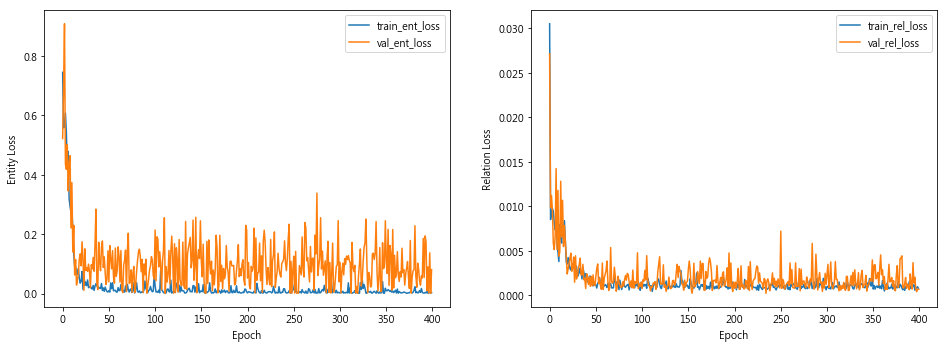

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# # Check predictions after training
# with torch.no_grad():
#     r_choose = random_choose(input_var)
#     model.eval()
#     ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
#                                        if USE_CUDA else batch_ent, isTrain=True)
    
#     batchsize = input_var[r_choose].size(0)
    
#     ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
#     ent_output = ent_argmax(ent_output, batchsize)
    
#     rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
#     print()
#     print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
#     print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
#     print()
#     print("Entity loss : %.4f" % ent_loss)
#     print("Relation loss : %.4f" % rel_loss)

In [15]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input, isTrain=False, silent=False):
    tps, fps, tns, fns = 0, 0, 0, 0
    y_ent_true_all, y_ent_pred_all = [], []
    y_rel_true_all, y_rel_pred_all = [], []
    print_every_batch = 5

    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)

            
            if not silent:
                print()    
                print("Entity loss : %.4f" % ent_loss)
                print("Relation loss : %.4f" % rel_loss)
                print()
                print('===========================================')
                
#             elif step%print_every_batch==0:
#                 print()    
#                 print("Entity loss : %.4f" % ent_loss)
#                 print("Relation loss : %.4f" % rel_loss)
#                 print()
#                 print('===========================================')
            else:
                pass

            tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel = \
            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel, silent)
            
            
            
            

            y_ent_true_all.extend(y_true_ent)
            y_ent_pred_all.extend(y_pred_ent)

            y_rel_true_all.extend(y_true_rel)
            y_rel_pred_all.extend(y_pred_rel)
            
            tps += tp
            fps += fp
            tns += tn
            fns += fn
        
        
        print()
        print("Entity detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_ent_true_all, y_ent_pred_all, average='micro', 
                                                  labels=range(len(schema['entity'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("Relation detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_rel_true_all, y_rel_pred_all, average='micro', 
                                              labels=range(len(schema['relation'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("ReferenceEntity+Relation score")
        print("%s \t %s \t %s \t    %s %s %s %s" % ('precision ', 'recall ', 'fbeta_score ', 'tp', 'fp', 'tn', 'fn'))
        p_r_f1 = p_r_fscore(tps, fps, tns, fns)
        print('%.3f \t\t %.3f \t\t %.3f \t\t    %d %d %d %d' % (p_r_f1[0], p_r_f1[1], p_r_f1[2], tps, fps, tns, fns))

            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel, silent):
    
    eval_ent_list_true_l, eval_rel_list_true_l = [], []
    eval_ent_list_pred_l, eval_rel_list_pred_l = [], []
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        if not silent:
            print(word_list)
            print(true_ent)
            print(true_r_list)
            print()
            print('Predict output')
            print(pridict_ent)
            print(pre_r_list)
            print()
            print('True')
            print(eval_ent_list_true)
            print(eval_rel_list_true)
            print('predict')
            print(eval_ent_list_pred)
            print(eval_rel_list_pred)
            print("=====================================")
        
        eval_ent_list_true_l.append(eval_ent_list_true)
        eval_rel_list_true_l.append(eval_rel_list_true)
        eval_ent_list_pred_l.append(eval_ent_list_pred)
        eval_rel_list_pred_l.append(eval_rel_list_pred)
    
    
    e_score, y_true_ent, y_pred_ent = get_scores(eval_ent_list_true_l, eval_ent_list_pred_l, \
                                                 range(len(schema['entity'])),output_y=True)
    r_score, y_true_rel, y_pred_rel = get_scores(eval_rel_list_true_l, eval_rel_list_pred_l, \
                                                 range(len(schema['relation'])),output_y=True)
    
    tp, fp, tn, fn = relation_error_analysis(eval_rel_list_true_l, eval_rel_list_pred_l)
    
    if not silent:
        print('Batch entity score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(e_score)
        print()
        print('Batch relation score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(r_score)
        print()
        print('p_r_fscore')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(p_r_fscore(tp, fp, tn, fn), tp, fp, tn, fn)
        print('===========================================')
    
    return tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = e_pairs
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(tuple(e_pairs_copy))
    
    return eval_rel_list
    
        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB
            

            
def get_scores(true_lists, pred_lists, labels, output_y=False):
    y_true, y_pred = [], []
    for t_list, p_list in zip(true_lists, pred_lists):
        yt, yp = align_yt_yp(t_list, p_list, labels)
        y_true.extend(yt)
        y_pred.extend(yp)
        
    scores = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels)
    return scores, y_true, y_pred if output_y else scores

def align_yt_yp(truths, predictions, labels):
    '''
    Input:
        truths/predictions: list of true and predicted tuples, 
        with the leading entries as the structure and the last entry as the class,
        e.g., [(e1, e2, rel), ...]
        labels: sequence of valid class
    Output:
        yt: list of true class given a structure
        yp: list of predicted class given a structure
    '''
    yt, yp = [], []
    _ID_NONE = len(labels)
    true_dict = { t[:-1]: t[-1] for t in truths }
    for p in predictions:
        yt.append(true_dict.pop(p[:-1], _ID_NONE))
        yp.append(p[-1])
    for target in true_dict.values():
        yt.append(target)
        yp.append(_ID_NONE)
    return yt, yp



def is_neg_triple(t):
    return np.imag(t[-1]) > 0

def negate_triple(t):
    # Mark negative triples with imaginary relation id
    return (t[0], t[1], np.real(t[-1]).item() + 1j)

def posit_triple(t):
    return (t[0], t[1], np.real(t[-1]).item())

def has_edge(base_ptrs, rel, e):
    '''
    Assume a relation exist between an entity pair, 
    if all the tokens in the base entity point to those in entity e.
    '''
    tok_has_ptr_to_e = [tok_ptrs[rel].ge(e[0]).dot(tok_ptrs[rel].le(e[1])).item() > 0 
                        for tok_ptrs in base_ptrs]
    return len(tok_has_ptr_to_e) > 0 and all(tok_has_ptr_to_e)


def relation_error_analysis(true_rel_lists, rel_lists):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i, r_list in enumerate(rel_lists):
        true_pos = len([t for t in r_list if t in true_rel_lists[i]])
        all_true = len([t for t in true_rel_lists[i] if not is_neg_triple(t)])
        all_pos = len(r_list)
        tp += true_pos
        fn += all_true - true_pos
        fp += all_pos - true_pos
        tn += len([t for t in true_rel_lists[i] if is_neg_triple(t) and posit_triple(t) not in r_list])
    return tp, fp, tn, fn

def p_r_fscore(tp, fp, tn, fn, beta=1, eps=1e-8):
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r + eps))
    return p, r, f_beta

In [16]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.0985
Relation loss : 0.0017

['在', '冬', '季', '再', '加', '一', '瓶', '乳', '霜', '就', '搞', '定', '保', '養', '步', '驟']
['O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(1, 2, 2)]
[]
predict
[(1, 2, 2)]
[]
['冬', '天', '風', '總', '是', '特', '別', '大', ',', '如', '果', '沒', '有', '做', '好', '保', '養', ',', '會', '感', '覺', '臉', '很', '緊', '繃', ',', '乾', '澀', '乾', '澀', '的', ',', '而', '在', '這', '種', '天', '氣', '下', ',', '使', '用', '這', '款', '乳', '液', '後', ',', '明', '顯', '覺', '得', '臉', '變', '的', '水', '潤', '、', '很', '保', '溼', ',', '對', '於', '偏', '油', '性', '膚', '質', '的', '我', '來', '說', ',', '這', '款', '乳', '液', '正', '是', '我', '需', '要', '的', '呢']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['不', '過', '夏', '天', '嘛', '.', '想', '清', '爽', '一', '點', '的', '人', ',', '它', '的', '保', '濕', '度', '還', '是', '夠', '的']
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '']

Predict output
['O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '']

True
[(2, 3, 2), (16, 18, 0)]
[((2, 3, 2), (16, 18, 0), 1)]
predict
[(2, 3, 2), (16, 18, 0)]
[]
['保', '濕', '度', '中', '等', '.', '不', '過', '冬', '天', '可', '能', '不', '合', '適', '.']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], [], '', '', '', '', '', [], [], '', '', ''

['保', '濕', '度', '在', '夏', '天', '倒', '是', '還', '不', '錯', ',']
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

True
[(0, 2, 0), (4, 5, 2)]
[((0, 2, 0), (4, 5, 2), 1)]
predict
[(0, 2, 0), (4, 5, 2)]
[((0, 2, 0), (4, 5, 2), 1)]
['敷', '完', '後', '眼', '周', '的', '肌', '膚', '很', '滋', '潤', ',', '的', '確', '有', '保', '濕', '的', '效', '果', ',', '隔', '天', '上', '妝', '也', '很', '著', '妝', ',', '是', '項', '很', '不', '錯', '的', '產', '品', ';', '但', '冬', '天', '使', '用', '可', '能', '會', '有', '點', '冷', 'X', 'D', ',', '因', '現', '在', '的', '天', '氣', '就', '很', '冰', '涼', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 

['很', '適', '合', '夏', '天', '使', '用', '的', '精', '華', '液', ',', '可', '以', '保', '濕', '但', '又', '不', '會', '過', '於', '油', '膩']
['O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

True
[(3, 4, 2), (14, 15, 0)]
[((3, 4, 2), (14, 15, 0), 1)]
predict
[(3, 4, 2), (14, 15, 0)]
[]
['最', '近', '的', '天', '氣', '變', '化', '很', '大', ',', '一', '下', '子', '冷', '一', '下', '子', '很', '熱', '的', ',', '所', '以', '我', '敏', '感', '的', '肌', '膚', '出', '現', '了', '乾', '燥', '泛', '紅', '以', '輕', '微', '脫', '皮', '的', '狀', '態', ',', '真', '的', '是

['這', '款', '對', '我', '這', '個', '敏', '感', '肌', '來', '說', '用', '也', '很', '棒', ',', '一', '些', '小', '泛', '紅', '都', '可', '以', '改', '善', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
predict
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
['我', '是', '混', '合', '肌', '.', 

['但', '保', '濕', '和', '控', '油', '都', '兼', '具', ',', '所', '以', '特', '別', '推', '薦', '混', '合', '肌', '使', '用', '喔']
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

Predict output
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O']
['', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '']

True
[(1, 2, 0), (16, 18, 1)]
[((1, 2, 0), (16, 18, 1), 0)]
predict
[(1, 2, 0), (16, 18, 1)]
[((1, 2, 0), (16, 18, 1), 0)]
['用', '了', '約', '半', '瓶', ',', '臉', '部', '保', '濕', '變', '高', ',', '臉', '也', '變', '的', '明', '亮', ',', '不', '過', '夏', '天', '我', '肌', '膚', '較', '容', '易', '出', '油', '的', '膚'

['我', '是', '混', '合', '肌', ',', '兩', '頰', '稍', '乾', ',', '那', '部', '分', '若', '沒', '加', '強', '保', '濕', ',', '直', '接', '使', '用', '這', '瓶', '會', '有', '點', '乾', '燥', '的', '感', '覺']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1), (18, 19, 0)]
[]
['其', '實', '產', '品', '本', '身', '的', '保', '濕', '度', '很', '優', ',', '很', '適', '

['像', '我', '自', '己', '是', '兩', '頰', '乾', '肌', '的', '在', '使', '用', '前', '敷', '點', '保', '濕', '或', '先', '用', '飾', '底', '乳', '打', '底']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

True
[(7, 8, 1)]
[]
predict
[(7, 8, 1), (16, 17, 0)]
[]
['這', '次', '所', '推', '出', '的', '是', '維', '他', '命', 'C', '升', '級', '版', ',', '裡', '面', '含', '有', '乙', '基', '維', '他', '命', 'C', ',', '加', '上', '兩', '種', '美', '白', '配', '方', '專', '利', '技', '術', ',', '還', '有', '特', '別', '添', '加', '抗', '敏', '成', '分', '讓', '敏', '感', '性', '肌', '膚', '也', '能', '使', '用'

['保', '濕', '的', '部', '份', '倒', '是', '覺', '得', '還', '可', '以', ',', '是', '有', '感', '覺', '比', '較', 'Q', '彈', '一', '點', ',', '夏', '天', '裡', '開', '冷', '氣', '常', '會', '讓', '皮', '膚', '太', '乾', ',', '但', '擦', '了', '這', '款', '乳', '液', '之', '後', '是', '有', '感', '覺', '皮', '膚', '在', '冷', '氣', '室', '裡', '沒', '那', '麼', '乾']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 

['『', 'E', 'V', 'I', 'T', 'A', '玫', '瑰', '泡', '沫', '潔', '顏', '慕', '斯', '』', '內', '含', '蜂', '王', '乳', '萃', '取', '精', '華', '、', '膠', '原', '蛋', '白', '、', '雙', '重', '玻', '尿', '酸', '、', '玫', '瑰', '水', '等', '成', '分', ',', '很', '適', '合', '肌', '膚', '外', '油', '內', '乾', '的', '我', ',', '最', '近', '剛', '好', '從', '炙', '熱', '的', '夏', '天', '轉', '換', '成', '秋', '季', ',', '正', '需', '要', '開', '始', '加', '強', '肌', '膚', '的', '保', '溼', '工', '作', ',', '就', '先', '從', '洗', '臉', '步', '驟', '做', '起']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '',

['整', '體', '來', '說', '保', '濕', '度', '還', '可', '以', ',', '但', '推', '薦', '夏', '天', '使', '用', ',', '冬', '天', '可', '能', '不', '夠', '力', ',', '吸', '收', '度', '還', '不', '錯', ',', '但', '我', '白', '天', '用', '了', '這', '瓶', '乳', '液', '之', '後', '變', '的', '很', '容', '易', '出', '油', ',', '所', '以', '我', '都', '晚', '上', '睡', '覺', '時', '才', '用']
['O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['乾', '肌', '可', '能', '就', '更', '顯', '保', '濕', '不', '夠', '力', '了']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '']

True
[(0, 1, 1), (7, 8, 0)]
[]
predict
[(0, 1, 1), (7, 8, 0)]
[((0, 1, 1), (7, 8, 0), 0)]
['我', '是', '屬', '於', '混', '合', '敏', '感', '肌', ',', 'T', '字', '部', '位', '出', '油', '但', '兩', '頰', '缺', '水', '乾', '襙', ',', '有', '時', '候', '天', '氣', '轉', '換', '兩', '頰', '還', '會', '過', '敏', ',', '而', '保', '養', '最', '重', '要', '的', '一', '道', '程', '序', '就', '是', '洗', '臉']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['但', '這', '保', '濕', '效', '果', '對', '於', '冬', '天', '來', '說', '可', '能', '有', '點', '點', '不', '夠', '力']
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '']

True
[(2, 3, 0), (8, 9, 2)]
[]
predict
[(2, 3, 0), (8, 9, 2)]
[((2, 3, 0), (8, 9, 2), 1)]
['本', '身', '是', '乾', '性', '肌', ',', '些', '微', '泛', '紅', ',', '後', '續', '仍', '要', '加', '上', '保', '濕', '產', '品']
['O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict o

['香', '味', '清', '淡', ',', '使', '用', '起', '來', '很', '水', '潤', ',', '又', '不', '黏', '膩', ',', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', ',', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', ',', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['夏', '天', '的', '白', '天', '擦', '這', '瓶', ',', '就', '很', '棒', ',', '剛', '剛', '好', '的', '保', '溼', ',', '又', '不', '會', '亂', '出', '油']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '']

True
[(0, 1, 2), (17, 18, 0)]
[((0, 1, 2), (17, 18, 0), 1)]
predict
[(0, 1, 2), (17, 18, 0)]
[]
Batch entity score
precision  	 recall  	 fbeta_score  	
(0.9, 0.9, 0.9, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(1.0, 0.5, 0.6666666666666666, None)

p_r_fscore
prec

In [17]:
# load test set

input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.839 		 0.894 		 0.865 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.562 		 0.510 		 0.535 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.562 		 0.510 		 0.535 		    50 39 0 48


In [34]:
def continue_train():
    
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
    criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
    
    n_iters = 10
    print_every = 12

    train_entloss_l = []
    val_entloss_l = []
    train_relloss_l = []
    val_relloss_l = []

    loss = 0
    
    for epoch in tqdm(range(n_iters)):  
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            batch_ent = batch_ent.view(batchsize*MAX_LEN)
            batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)

            entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
            relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
            loss = entloss+relloss

            loss.backward()
            optimizer.step()


        train_entloss_l.append(entloss.cpu())
        train_relloss_l.append(relloss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))

        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
            val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))

        val_entloss_l.append(val_entloss.cpu())
        val_relloss_l.append(val_relloss.cpu())

        
        
#         evaluate_data(loader, raw_input, isTrain=True, silent=True)
        
        print()
        print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
              % (epoch+1, entloss, relloss, loss))
        print("      %s  | val ent loss %.4f | val rel loss %.4f"
              % (" "*len(str(epoch+1)), val_entloss, val_relloss))
        

In [35]:
continue_train()

 10%|█         | 1/10 [00:09<01:29,  9.99s/it]


epoch: 1 | ent loss 0.0459 | rel loss 0.0009 | total loss 0.0468
         | val ent loss 0.1390 | val rel loss 0.0023


 20%|██        | 2/10 [00:20<01:23, 10.40s/it]


epoch: 2 | ent loss 0.0211 | rel loss 0.0011 | total loss 0.0221
         | val ent loss 0.1028 | val rel loss 0.0013


 30%|███       | 3/10 [00:31<01:14, 10.60s/it]


epoch: 3 | ent loss 0.0016 | rel loss 0.0005 | total loss 0.0021
         | val ent loss 0.0259 | val rel loss 0.0007


 40%|████      | 4/10 [00:42<01:04, 10.67s/it]


epoch: 4 | ent loss 0.0010 | rel loss 0.0008 | total loss 0.0018
         | val ent loss 0.1431 | val rel loss 0.0017


 50%|█████     | 5/10 [00:53<00:53, 10.75s/it]


epoch: 5 | ent loss 0.0012 | rel loss 0.0006 | total loss 0.0018
         | val ent loss 0.0783 | val rel loss 0.0021


 60%|██████    | 6/10 [01:04<00:43, 10.82s/it]


epoch: 6 | ent loss 0.0130 | rel loss 0.0009 | total loss 0.0139
         | val ent loss 0.0337 | val rel loss 0.0011


 70%|███████   | 7/10 [01:16<00:32, 10.86s/it]


epoch: 7 | ent loss 0.0042 | rel loss 0.0011 | total loss 0.0053
         | val ent loss 0.0767 | val rel loss 0.0007


 80%|████████  | 8/10 [01:27<00:21, 10.89s/it]


epoch: 8 | ent loss 0.0197 | rel loss 0.0013 | total loss 0.0209
         | val ent loss 0.0810 | val rel loss 0.0007


 90%|█████████ | 9/10 [01:38<00:10, 10.90s/it]


epoch: 9 | ent loss 0.0201 | rel loss 0.0008 | total loss 0.0209
         | val ent loss 0.0779 | val rel loss 0.0037


100%|██████████| 10/10 [01:49<00:00, 10.92s/it]


epoch: 10 | ent loss 0.0040 | rel loss 0.0012 | total loss 0.0051
          | val ent loss 0.0704 | val rel loss 0.0007


In [36]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.0580
Relation loss : 0.0010

['香', '味', '清', '淡', ',', '使', '用', '起', '來', '很', '水', '潤', ',', '又', '不', '黏', '膩', ',', '比', '一', '般', '保', '濕', '化', '妝', '水', '保', '濕', ',', '卻', '又', '不', '會', '使', '皮', '膚', '出', '油', ',', '很', '好', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

['質', '地', '清', '爽', '不', '油', '膩', ',', '吸', '收', '滲', '透', '度', '可', '能', '不', '會', '很', '迅', '速', ',', '但', '維', '持', '度', '佳', ',', '可', '能', '因', '為', '適', '用', '時', '間', '是', '冬', '天', ',', '加', '上', '我', '的', '皮', '膚', '不', '算', '黑', ',', '美', '白', '的', '效', '果', '顯', '現', '上', '不', '是', '很', '明', '顯', ',', '不', '過', '若', '是', '夏', '天', '用', '應', '該', '效', '果', '會', '不', '錯', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '',

['擦', '在', '臉', '上', '非', '常', '的', '滋', '潤', '.', '尤', '其', '現', '在', '冬', '天', '.', '真', '是', '一', '整', '個', '保', '濕', '啊']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '']

True
[(14, 15, 2), (22, 23, 0)]
[((14, 15, 2), (22, 23, 0), 1)]
predict
[(14, 15, 2), (22, 23, 0)]
[((14, 15, 2), (22, 23, 0), 1)]
['因', '為', '本', '身', '是', '敏', '感', '肌', '的', '關', '係', ',', '使', '用', '美', '白', '類', '的', '產', '品', '特', '別', '注', '意', '小', '心

['此', '款', '粉', '底', '液', '最', '大', '的', '特', '色', '為', '長', '達', '1', '2', '小', '時', '保', '溼', '度', ',', '且', '輕', '爽', '不', '黏', '膩', ',', '即', '使', '在', '炎', '熱', '又', '悶', '熱', '的', '夏', '天', '使', '用', ',', '也', '仍', '保', '有', '完', '好', '無', '瑕', '的', '妝', '容', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

Batch entity score
precision  	 recall  	 fbeta_score  	
(0.953125, 0.9682539682539683, 0.9606299212598425, None)

Batch relation score
precision  	 recall  	 fbeta_score  	
(0.8095238095238095, 0.85, 0.8292682926829269, None)

p_r_fscore
precision  	 recall  	 fbeta_score  	
(0.809523809138322, 0.8499999995749999, 0.8292682872813802) 17 4 0 3

Entity loss : 0.0743
Relation loss : 0.0016

['產', '品', '的', '質', '地', '和', '某', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '很', '像', ',', '過', '去', '皮', '膚', '過', '敏', '期', '曾', '使', '用', '藥', '妝', '品', '牌', '的', '修', '護', '霜', '來', '舒', '緩', '肌', '膚', '的', '不', '適', ',', '所', '以', '對', '這', '樣', '的', '質', '地', '且', '同', '為', '修', '護', '霜', ',', '初', '次', '使', '用', '便', '有', '了', '安', '心', '感']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['看', '了', '一', '下', '商', '品', '說', '明', ',', '了', '解', '這', '項', '產', '品', '主', '要', '訴', '求', '就', '是', '保', '濕', ',', '連', '夏', '天', '在', '冷', '氣', '房', '會', '造', '成', '的', '乾', '燥', '肌', '膚', '也', '很', '適', '合', '使', '用']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', [], [], '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', ''

['冬', '天', '時', '我', '的', '肌', '膚', '又', '特', '別', '容', '易', '乾', '癢', ',', '擦', '了', '好', '幾', '道', '的', '保', '濕', '不', '僅', '不', '夠', '還', '得', '再', '擦', '上', '厚', '厚', '的', '乳', '霜', ',', '有', '時', '還', '是', '會', '很', '難', '上', '妝']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[[], [], '', '', '', [], [], '', '', '', '', '', '', '', 

['乾', '性', '肌', '使', '用', '起', '來', '非', '常', '的', '保', '濕', ',']
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

Predict output
['B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '']

True
[(0, 2, 1), (10, 11, 0)]
[((0, 2, 1), (10, 11, 0), 0)]
predict
[(0, 2, 1), (10, 11, 0)]
[((0, 2, 1), (10, 11, 0), 0)]
['敷', '完', '後', '眼', '周', '的', '肌', '膚', '很', '滋', '潤', ',', '的', '確', '有', '保', '濕', '的', '效', '果', ',', '隔', '天', '上', '妝', '也', '很', '著', '妝', ',', '是', '項', '很', '不', '錯', '的', '產', '品', ';', '但', '冬', '天', '使', '用', '可', '能', '會', '有', '點', '冷', 'X', 'D', ',', '因', '現', '在', '的', '天', '氣', '就', '很', '冰', '涼', '了']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

['保', '濕', '效', '果', '倒', '是', '還', '不', '錯', '~', '至', '少', '我', '這', '種', '敏', '感', '肌', '這', '陣', '子', '都', '沒', '有', '再', '出', '現', '乾', '癢', '脫', '皮', '的', '現', '象']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 0),

['我', '是', '混', '合', '肌', '.', '.', '.', '最', '怕', '使', '用', '保', '濕', '的', '東', '西', '.', '.', '油', '油', '又', '黏', '黏', '的', '.', '.']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '']

True
[(2, 4, 1)]
[]
predict
[(2, 4, 1), (19, 20, 1)]
[]
['所', '以', '每', '次', '擦', '拭', '完', '全', '臉', '後', ',', '我', '都', '還', '會', '在', '加', '強', '的', '擦', '拭', '在', '木', '偶', '紋', '附', '近', ',', '結', '果', '真', '的', '變', '得', '有', '比', '較', '不', '緊', '繃', '了', ',', '但', '是', '其', '他', '部', '位', '却', '沒', '有', '感', 

['早', '上', '起', '來', ',', '正', '常', '保', '養', '程', '序', '後', '~', '隔', '離', '霜', '~', '粉', '底', '液', '~', '後', '接', '著', '使', '用', '粉', '餅', '~', '這', '是', '我', '的', '習', '慣', '~', '因', '為', '冬', '天', '肌', '膚', '狀', '態', '比', '較', '乾', '燥', '~', '所', '以', '我', '都', '是', '在', '粉', '底', '液', '後', '使', '用', '粉', '餅']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

[]
['再', '加', '上', '它', '的', '保', '濕', '效', '果', '很', '讓', '我', '滿', '意', ',', '我', '是', '乾', '性', '肌', '膚', ',', '用', '起', '來', '蠻', '夠', '保', '濕', '的', ',']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyT

['保', '溼', '度', ':', '佳', ',', '夏', '天', '適', '用']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O']
[['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '']

True
[(0, 1, 0), (6, 7, 2)]
[((0, 1, 0), (6, 7, 2), 1)]
predict
[(0, 1, 0), (6, 7, 2)]
[((0, 1, 0), (6, 7, 2), 1)]
['『', 'E', 'V', 'I', 'T', 'A', '玫', '瑰', '泡', '沫', '潔', '顏', '慕', '斯', '』', '內', '含', '蜂', '王', '乳', '萃', '取', '精', '華', '、', '膠', '原', '蛋', '白', '、', '雙', '重', '玻', '尿', '酸', '、', '玫', '瑰', '水', '等', '成', '分', ',', '很', '適', '合', '肌', '膚', '外', '油', '內', '乾', '的', '我', ',', '最', '近', '剛', '好', '從', '炙', '熱', '的', '夏', '天', '轉', '換', '成', '秋', '季', ',', '正', '需', '要', '開', '始', '加', '強', '肌', '膚', '的', '保', '溼', '工', '作', ',', '就', '先', '從', '洗', '臉', '步', '驟', '做', '起']
['O', 'O', 'O

['這', '款', '對', '我', '這', '個', '敏', '感', '肌', '來', '說', '用', '也', '很', '棒', ',', '一', '些', '小', '泛', '紅', '都', '可', '以', '改', '善', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
predict
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
['看', '到', '特', '級', '保', '溼', 

In [37]:
evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.865 		 0.895 		 0.880 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.631 		 0.663 		 0.647 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.631 		 0.663 		 0.647 		    65 38 0 33


In [38]:
evaluate_data(dev_loader, raw_input_dev, isTrain=False)


Entity loss : 0.0477
Relation loss : 0.0033

['夏', '天', '想', '要', '保', '濕', '又', '怕', '油', '膩', '的', '大', '大', '們', ',', '這', '會', '是', '你', '絕', '佳', '的', '選', '擇', '歐', ',', '推', '薦', '給', '大', '家', '使', '用', '看', '看', '歐']
['B-SEAS', 'I-SEAS', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['結', '合', '多', '糖', '體', '、', '甘', '菊', '、', '山', '楂', '、', '牡', '丹', '等', '天', '然', '植', '物', '活', '性', '精', '華', ',', '還', '有', '維', '他', '命', 'B', '5', '、', '白', '藜', '蘆', '醇', '等', '的', '專', '利', '鎮', '定', '複', '合', '成', '分', ',', '對', '於', '敏', '感', '肌', '膚', '的', '泛', '紅', '症', '狀', ',', '可', '以', '立', '即', '鎮', '定', '舒', '緩', ',', '讓', '膚', '色', '呈', '現', '均', '勻', '樣', ',', '是', '一', '款', '很', '有', '修', '護', '防', '禦', '的', '精', '華', '液', '唷']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '

['這', '款', '面', '膜', '的', '保', '濕', '度', '相', '當', '不', '錯', ',', '敷', '了', '1', '5', '分', '鐘', '取', '下', '後', ',', '臉', '上', '還', '有', '飽', '飽', '的', '水', '感', ',', '不', '會', '黏', '黏', '悶', '悶', ',', '整', '個', '吸', '收', '度', '很', '好', ',', '臉', '部', '肌', '膚', '有', '細', '緻', '明', '亮', '水', '感', ',', '不', '是', '油', '光', '喔', ',', '隔', '天', '也', '維', '持', '一', '天', ',', '明', '顯', '感', '受', '毛', '孔', '淨', '化', '和', '控', '油', ',', '很', '適', '合', '夏', '天', '使', '用']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O']
['', '', '', '', '', ['ApplyIn-0-

['保', '濕', '效', '果', '倒', '是', '還', '不', '錯', '~', '至', '少', '我', '這', '種', '敏', '感', '肌', '這', '陣', '子', '都', '沒', '有', '再', '出', '現', '乾', '癢', '脫', '皮', '的', '現', '象']
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

True
[(0, 1, 0),


Entity loss : 0.0663
Relation loss : 0.0042

['因', '為', '本', '人', '皮', '膚', '是', '屬', '於', '比', '較', '中', '性', '偏', '乾', '敏', '感', '肌', ',', '所', '以', '在', '選', '擇', '保', '養', '品', '最', '怕', '就', '是', '會', '過', '敏', '、', '紅', '腫', '、', '癢', ',', '或', '是', '保', '養', '使', '用', '後', '臉', '部', '呈', '現', '出', '濕', '黏', '的', '狀', '態', '會', '很', '不', '舒', '服']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['乾', '肌', '可', '能', '就', '更', '顯', '保', '濕', '不', '夠', '力', '了']
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], '', '', '', '']

Predict output
['B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O']
[['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '']

True
[(0, 1, 1), (7, 8, 0)]
[]
predict
[(0, 1, 1), (7, 8, 0)]
[((0, 1, 1), (7, 8, 0), 0)]
['他', '的', '保', '濕', '度', '算', '普', '通', ',', '對', '一', '般', '肌', '膚', '、', '中', '性', '肌', '膚', '保', '濕', '度', '夠', ',', '不', '過', '對', '乾', '性', '肌', '膚', '保', '濕', '度', '就', '略', '為', '不', '足']
['O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0

['質', '地', '清', '爽', '不', '油', '膩', ',', '吸', '收', '滲', '透', '度', '可', '能', '不', '會', '很', '迅', '速', ',', '但', '維', '持', '度', '佳', ',', '可', '能', '因', '為', '適', '用', '時', '間', '是', '冬', '天', ',', '加', '上', '我', '的', '皮', '膚', '不', '算', '黑', ',', '美', '白', '的', '效', '果', '顯', '現', '上', '不', '是', '很', '明', '顯', ',', '不', '過', '若', '是', '夏', '天', '用', '應', '該', '效', '果', '會', '不', '錯', '喔']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '',

['這', '款', '對', '我', '這', '個', '敏', '感', '肌', '來', '說', '用', '也', '很', '棒', ',', '一', '些', '小', '泛', '紅', '都', '可', '以', '改', '善', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
predict
[(6, 8, 1), (26, 27, 0)]
[((6, 8, 1), (26, 27, 0), 0)]
['冬', '天', '用', '它', '應', '該', 

['像', '我', '自', '己', '是', '兩', '頰', '乾', '肌', '的', '在', '使', '用', '前', '敷', '點', '保', '濕', '或', '先', '用', '飾', '底', '乳', '打', '底']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '']

True
[(7, 8, 1)]
[]
predict
[(16, 17, 0)]
[]
['原', '本', '肌', '膚', '敏', '感', '泛', '紅', '的', '部', '分', '也', '舒', '緩', '許', '多']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-0-A'], ['App


Entity loss : 0.0986
Relation loss : 0.0038

['◎', '洋', '甘', '菊', '精', '華', ':', '舒', '緩', '肌', '膚', '敏', '感', '不', '適']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '']

True
[(7, 8, 0), (9, 12, 1)]
[((7, 8, 0), (9, 12, 1), 0)]
predict
[(7, 8, 0), (9, 12, 1)]
[((7, 8, 0), (9, 12, 1), 0)]
['此', '款', '粉', '底', '液', '最', '大', '的', '特', '色', '為', '長', '達', '1', '2', '小', '時', '保', '溼', '度', ',', '且', '輕', '爽', '不', '黏', '膩', ',', '即', '使', '在', '炎', '熱', '又', '悶', '熱', '的', '夏', '天', '使', '用', ',', '也', '仍', '保', '有', '完', '好', '無', '瑕', '

['夏', '天', '用', '太', '黏', '膩', '~', '冬', '天', '的', '話', '會', '不', '夠', '保', '濕', '~', '我', '會', '放', '在', '秋', '天', '當', '保', '濕', '精', '華', '用']
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O']
[[], [], '', '', '', '', '', [], [], '', '', '', '', '', [], [], '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '']

Predict output
['B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
[['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', [], [], '', '', '', '', '', ['ApplyIn-1-A'], ['ApplyIn-1-A'], '', '', '', '', '', ['ApplyIn-1-B'], ['ApplyIn-1-B'], '', '', '', '', '', '']

True
[(0, 1, 2), (7, 8, 2), (14, 15, 0), (21, 22, 2), (24, 25, 0)]
[((21, 22, 2), (24, 25, 

['但', '保', '濕', '效', '果', '還', '算', '不', '錯', ',', '抹', '完', '再', '塗', '防', '曬', '也', '不', '覺', '得', '太', '油', '膩', ',', '只', '是', '冬', '天', '用', '感', '覺', '更', '適', '合']
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
['', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

Predict output
['O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O']
['', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '']

True
[(1, 2, 0), (26, 27, 2)]
[((1, 2, 0), (26, 27, 

['再', '加', '上', '它', '的', '保', '濕', '效', '果', '很', '讓', '我', '滿', '意', ',', '我', '是', '乾', '性', '肌', '膚', ',', '用', '起', '來', '蠻', '夠', '保', '濕', '的', ',']
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], ['ApplyTo-1-B', 'ApplyTo-0-B'], '', '', '', '', '', '', ['ApplyTo-1-A'], ['ApplyTo-1-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0

['也', '可', '以', '舒', '緩', '及', '消', '除', '眼', '部', '浮', '腫', ',', '冬', '天', '使', '用', '還', '有', '提', '神', '的', '效', '果', '^', '^']
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SEAS', 'I-SEAS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', ['ApplyIn-0-A'], ['ApplyIn-0-A'], '', '', '', '', '', '', '', '', ['ApplyIn-0-B'], ['ApplyIn-0-B'], '', '', '', '', '', '', '', '', '', '', '']

True
[(3, 4, 0), (13, 14, 2)]
[((3, 4, 0), (13, 14, 2), 1)]
predict
[(3, 4, 0), (13, 14, 2)]
[((3, 4, 0), (13, 14, 2), 1)]
['不', '過', '對', '於', '冬', '天', '的', '眼', '周', '肌', '膚', '似', '乎', '不', '夠', '保', '濕']
['O', 'O', 'O', 'O', 'B-SEA

In [39]:
evaluate_data(test_loader, raw_input_test, isTrain=False, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.865 		 0.895 		 0.880 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.710 		 0.673 		 0.691 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.710 		 0.673 		 0.691 		    66 27 0 32


In [25]:
len(input_var), len(input_dev), len(input_test)

(788, 101, 200)